## **Comparing the performace of VOGN and Adam on MNIST dataset by performing Active Learning**

### *Group 15*
#### Om Shri Prasath - EE17B113
#### Tamil Sudaravan - EE18B119
#### Kaousheik - EE18B134
#### Ramanan - EE18B145

In [2]:
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/sudhirmts/code/Users/tamilsudaravan


In [3]:
# setting up pytorchsso
!nvcc --version
!pip install cupy-cuda101
# !git clone https://github.com/cybertronai/pytorch-sso.git
%cd pytorch-sso/
!python setup.py install

/bin/bash: nvcc: command not found
/mnt/batch/tasks/shared/LS_root/mounts/clusters/sudhirmts/code/Users/tamilsudaravan/pytorch-sso
running install
running bdist_egg
running egg_info
writing torchsso.egg-info/PKG-INFO
writing dependency_links to torchsso.egg-info/dependency_links.txt
writing requirements to torchsso.egg-info/requires.txt
writing top-level names to torchsso.egg-info/top_level.txt
writing manifest file 'torchsso.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/torchsso
creating build/bdist.linux-x86_64/egg/torchsso/autograd
copying build/lib/torchsso/autograd/samplegrad.py -> build/bdist.linux-x86_64/egg/torchsso/autograd
copying build/lib/torchsso/autograd/__init__.py -> build/bdist.linux-x86_64/egg/torchsso/autograd
creating build/bdist.linux-x86_64/egg/torchsso/curv
creating build/bdist.linux-x86_64/egg/torchsso/curv/cov
copying 

In [13]:
!pip install chainer

In [2]:
# Importing necessary libraries

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchsso
import torchvision
import torch.optim as optim

import numpy as np
import pandas as pd
from numpy import random

import warnings
warnings.filterwarnings("ignore")

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/chainer-7.7.0-py3.6.egg/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda101) version 9.1.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda101>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [3]:
# Using GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

cuda


In [4]:
# Initializing parameters
n_epochs = 6
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
Train_size = -1

In [5]:
# Function to filter classes 1, 7 from MNIST dataset
def get_data(classes=[0,1]):

  # Seperating train and test data
  train_data = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
  test_data =   torchvision.datasets.MNIST('./files/', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
  
  print("Training Samples :",len(train_data))
  print("Testing Samples  :",len(test_data))
  

  return train_data, test_data

In [6]:
train_data, test_data = get_data() #(13007,1,28,28)
Train_size = len(train_data)
# setting up train_loader and test_loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

Training Samples : 60000
Testing Samples  : 10000


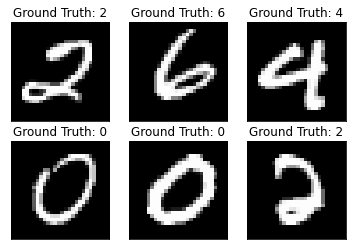

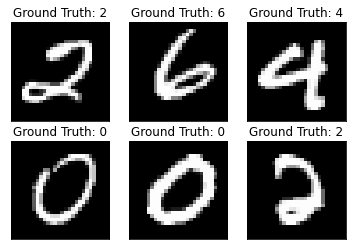

In [8]:
# Plotting a few examples from the taken classes 1, 7 and their truth values
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  # plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

#**Active Learning** 

In [9]:
# Defining the Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
# Optimizer for VOGN
network = Net()
optimizer = torchsso.optim.VOGN(network, dataset_size=len(train_loader.dataset))

# Optimizer for Adam
network2 = Net()
optimizer2 = torch.optim.Adam(network2.parameters(), lr = learning_rate)

In [11]:
# Function to train the model 
def train(train_itr, epoch, algo="vogn"):
  if algo == "vogn":
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_itr):
      def closure():
          optimizer.zero_grad()
          output = network(data)
          loss = F.cross_entropy(output, target)
          loss.backward()
          return loss, output
      loss , output = optimizer.step(closure)
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_itr.dataset),
          100. * batch_idx / len(train_itr), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_itr.dataset)))
  elif algo=="adam":
    network2.train()

    for batch_idx, (data, target) in enumerate(train_itr):
      def closure2():
        optimizer2.zero_grad()
        output = network2(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        return loss, output
      
      loss, output = optimizer2.step(closure2)

      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_itr.dataset),
          100. * batch_idx / len(train_itr), loss.item()))
        train_losses_adam.append(loss.item())
        train_counter_adam.append(
          (batch_idx*64) + ((epoch-1)*len(train_itr.dataset)))

In [12]:
# Function to test the model for Adam and VOGN
def test(algo="vogn"):
  if algo == "vogn":
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    
  elif algo == "adam":
    network2.eval()
    test_loss = 0
    correct =0
    with torch.no_grad():
      for data, target in test_loader:
        output = network2(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_adam.append(test_loss)
    test_acc_adam.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [14]:
# Declaring constants
N = Train_size
N_initial = 100
N_add = 20
N_iter = 30
mean = 0.1307
std = 0.3081

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []

train_losses_adam = []
train_counter_adam = []
test_losses_adam = []
test_counter_adam = test_counter
test_acc_adam = []

In [16]:
# Reshaping the Training data in (X, 1, 28, 28 ) form
X_pool = train_data.data.numpy() 
X_pool = X_pool.reshape(X_pool.shape[0], 1, X_pool.shape[1], X_pool.shape[2]) #(13007, 28, 28) --> (13007, 1, 28, 28) 
X_pool = X_pool/255.
X_pool = (X_pool-mean)/std
y_pool = train_data.targets.numpy()
print(X_pool.shape,y_pool.shape)

(60000, 1, 28, 28) (60000,)


In [17]:
# Function to calculate entropy
def get_entropy(prob: torch.Tensor):
    entropy = - prob[:,0] * torch.log(prob[:,0])
    for i in range(prob.shape[1]):
      if i != 0:
        entropy -=  prob[:,i] * torch.log(prob[:,i])
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()
    return entropy

In [18]:
# Function to get tensor iterator (used by torch model) from numpy array
def get_tensor_iterator(X,y,batch_size=32):
  X_tensor = torch.from_numpy(X).type(torch.float)
  y_tensor = torch.from_numpy(y).type(torch.LongTensor)
  train_dataset = TensorDataset(X_tensor, y_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size)
  return train_loader

In [19]:
# Function that return the datapoints required for a particular iteration
def get_train_data(X_pool, y_pool, high_entropy):
  X_train,y_train = [],[]

  for i in range(len(X_pool)):
    if i in high_entropy:
      X_train.append(X_pool[i])
      y_train.append(y_pool[i])
  
  X_train, y_train = np.array(X_train), np.array(y_train)
  
  return X_train, y_train

In [20]:
# Function that calculates entropy and returns High entropy indices 
def get_high_entropy_indices(train_inds, X, y, algo="vogn"):
 
  X_c = []
  inds = []
  for i in range(len(X)):
    if i not in train_inds:
      X_c.append(X[i])
      inds.append(i)
  
  X_samples = np.array(X_c)
  X_samples = torch.from_numpy(X_samples).type(torch.float)

  if algo == "vogn":
    network.eval()
    prob = optimizer.prediction(X_samples, mc=15)
  elif algo == "adam":
    network2.eval()
    prob = torch.sigmoid(network2(X_samples))
  else:
    print("Invalid Algorithm ;(")


  entropy = get_entropy(prob)

  ind_pair_arr = []
  for i in range(len(entropy)):
    ind_pair_arr.append([entropy[i],inds[i]]) 
  ind_pair_arr.sort(reverse=True)

  high_ent_inds = []
  for i in range(N_add):
    high_ent_inds.append(ind_pair_arr[i][1])
  
  return high_ent_inds


VOGN train Data Size:  (100, 1, 28, 28)
Train Epoch: 1 [0/100 (0%)]	Loss: 2.325550
Train Epoch: 2 [0/100 (0%)]	Loss: 2.308115
Train Epoch: 3 [0/100 (0%)]	Loss: 2.280892
Train Epoch: 4 [0/100 (0%)]	Loss: 2.240086
Train Epoch: 5 [0/100 (0%)]	Loss: 2.186177
Train Epoch: 6 [0/100 (0%)]	Loss: 2.076478

Test set: Avg. loss: 1.8932, Accuracy: 3340/10000 (33%)



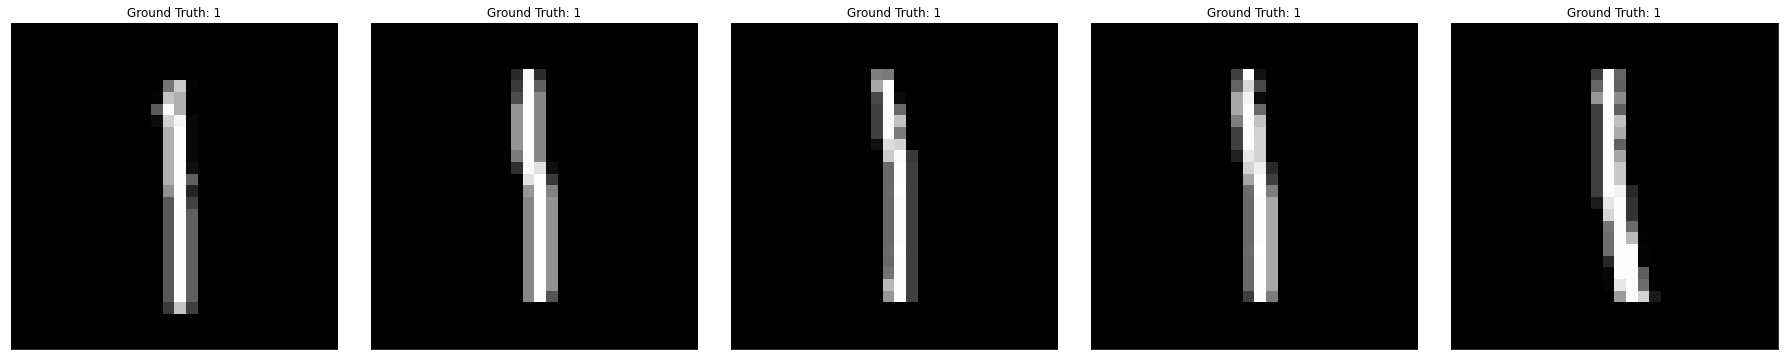

Adam train Data Size:  (100, 1, 28, 28)
Train Epoch: 1 [0/100 (0%)]	Loss: 2.338570
Train Epoch: 2 [0/100 (0%)]	Loss: 2.230168
Train Epoch: 3 [0/100 (0%)]	Loss: 2.190381
Train Epoch: 4 [0/100 (0%)]	Loss: 1.983441
Train Epoch: 5 [0/100 (0%)]	Loss: 1.843069
Train Epoch: 6 [0/100 (0%)]	Loss: 1.739841

Test set: Avg. loss: 1.5533, Accuracy: 5620/10000 (56%)



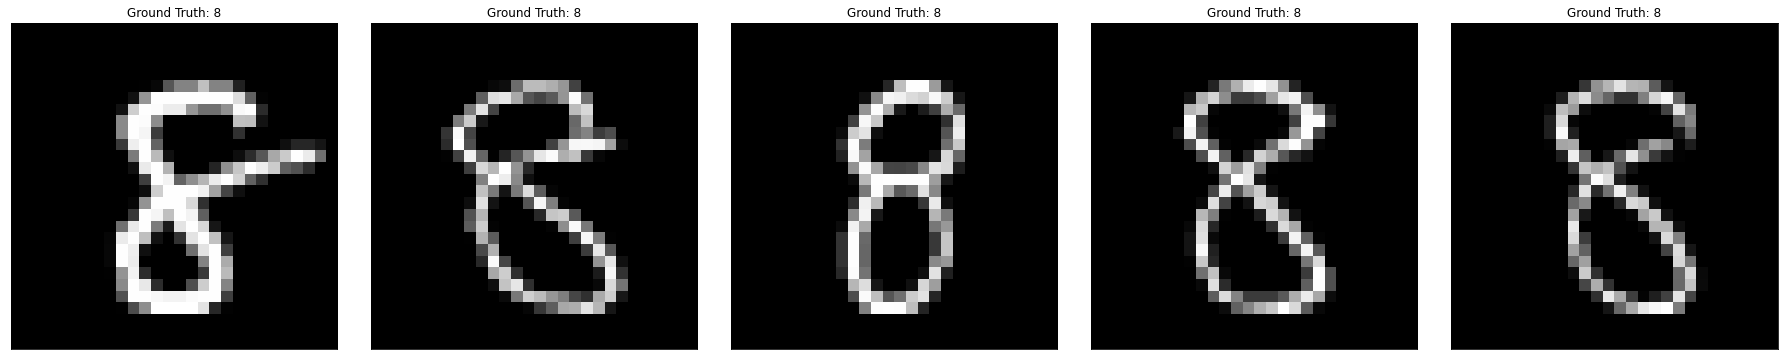

VOGN train Data Size:  (120, 1, 28, 28)
Train Epoch: 1 [0/120 (0%)]	Loss: 1.997151
Train Epoch: 2 [0/120 (0%)]	Loss: 1.840309
Train Epoch: 3 [0/120 (0%)]	Loss: 1.673720
Train Epoch: 4 [0/120 (0%)]	Loss: 1.514994
Train Epoch: 5 [0/120 (0%)]	Loss: 1.376000
Train Epoch: 6 [0/120 (0%)]	Loss: 1.235628

Test set: Avg. loss: 1.0782, Accuracy: 6671/10000 (67%)



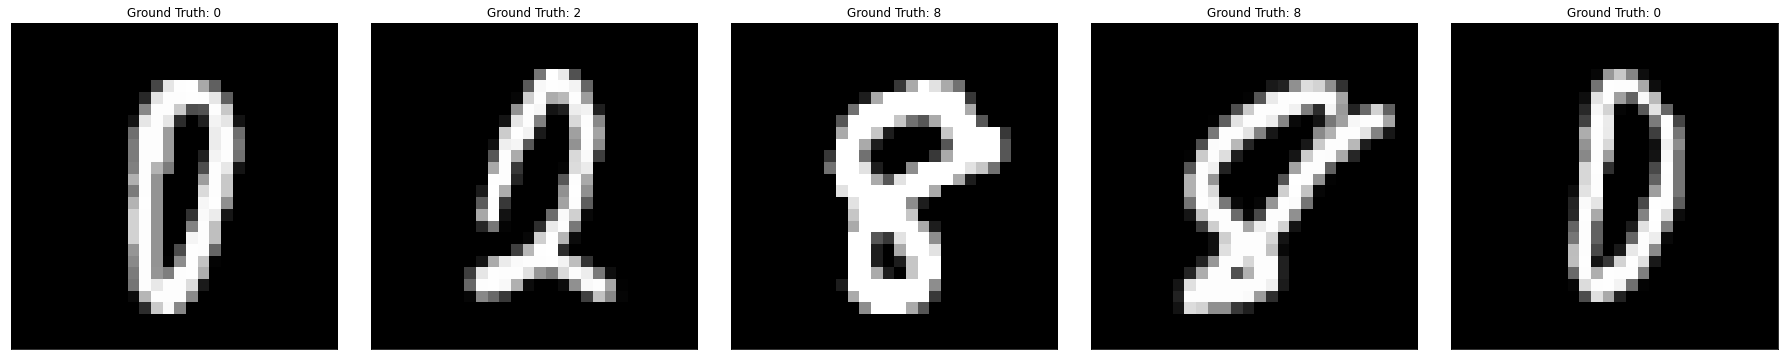

Adam train Data Size:  (120, 1, 28, 28)
Train Epoch: 1 [0/120 (0%)]	Loss: 1.733060
Train Epoch: 2 [0/120 (0%)]	Loss: 1.739457
Train Epoch: 3 [0/120 (0%)]	Loss: 1.662514
Train Epoch: 4 [0/120 (0%)]	Loss: 1.522411
Train Epoch: 5 [0/120 (0%)]	Loss: 1.296675
Train Epoch: 6 [0/120 (0%)]	Loss: 1.196367

Test set: Avg. loss: 0.8548, Accuracy: 7490/10000 (75%)



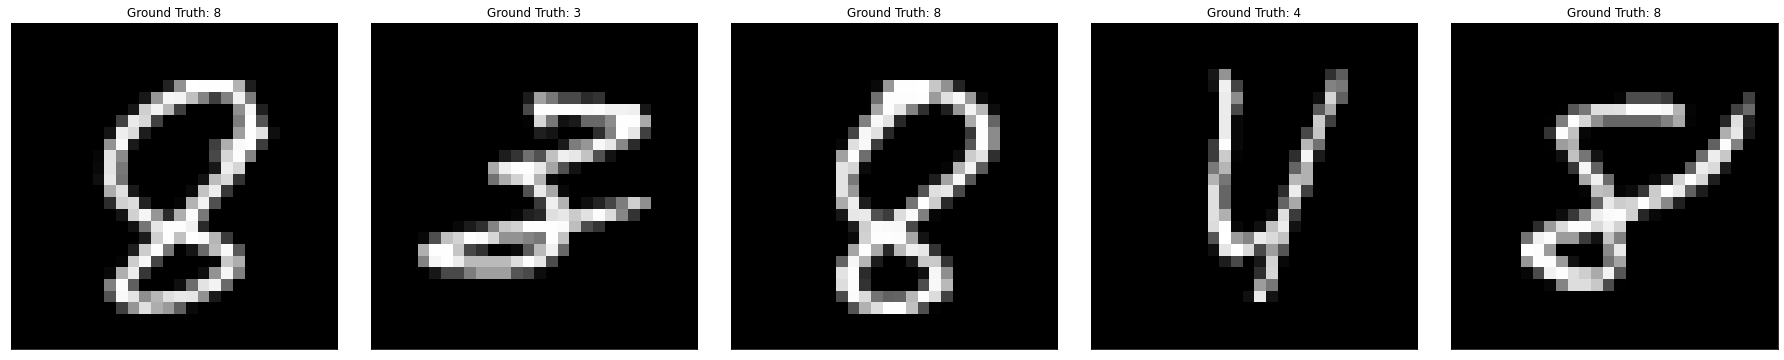

VOGN train Data Size:  (140, 1, 28, 28)
Train Epoch: 1 [0/140 (0%)]	Loss: 1.403798
Train Epoch: 2 [0/140 (0%)]	Loss: 1.187447
Train Epoch: 3 [0/140 (0%)]	Loss: 1.075573
Train Epoch: 4 [0/140 (0%)]	Loss: 1.010951
Train Epoch: 5 [0/140 (0%)]	Loss: 0.891776
Train Epoch: 6 [0/140 (0%)]	Loss: 0.848474

Test set: Avg. loss: 0.7298, Accuracy: 7620/10000 (76%)



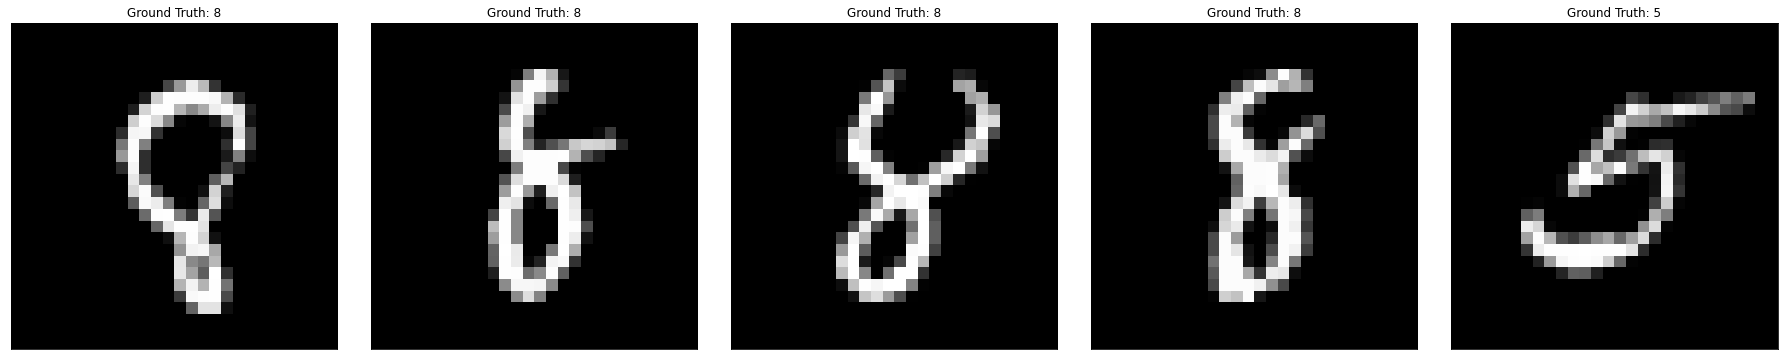

Adam train Data Size:  (140, 1, 28, 28)
Train Epoch: 1 [0/140 (0%)]	Loss: 1.201239
Train Epoch: 2 [0/140 (0%)]	Loss: 1.318958
Train Epoch: 3 [0/140 (0%)]	Loss: 1.333150
Train Epoch: 4 [0/140 (0%)]	Loss: 1.215982
Train Epoch: 5 [0/140 (0%)]	Loss: 1.235719
Train Epoch: 6 [0/140 (0%)]	Loss: 1.114208

Test set: Avg. loss: 0.5675, Accuracy: 8333/10000 (83%)



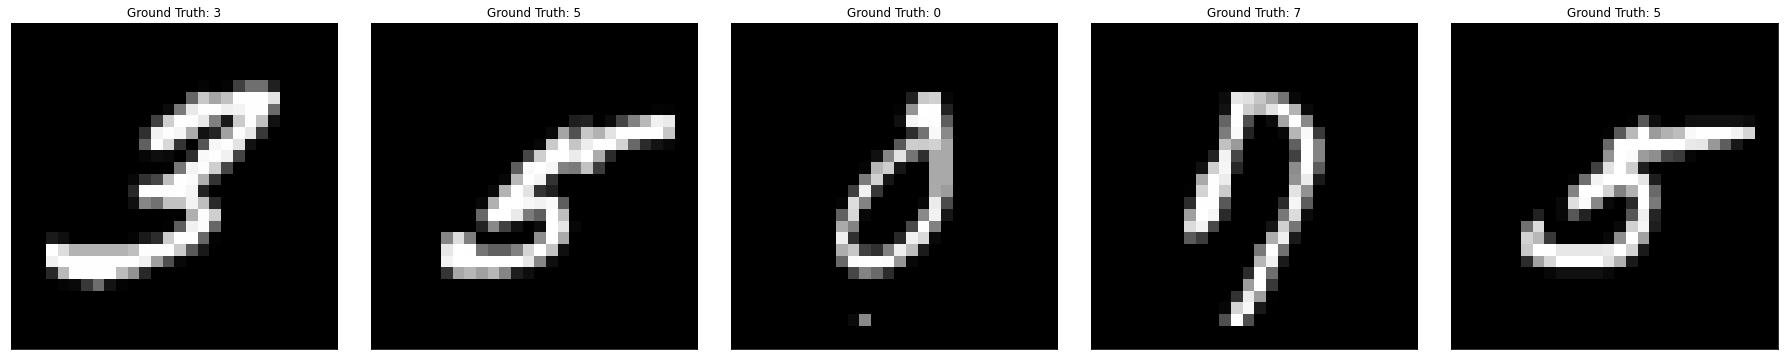

VOGN train Data Size:  (160, 1, 28, 28)
Train Epoch: 1 [0/160 (0%)]	Loss: 0.955278
Train Epoch: 2 [0/160 (0%)]	Loss: 0.880590
Train Epoch: 3 [0/160 (0%)]	Loss: 0.854912
Train Epoch: 4 [0/160 (0%)]	Loss: 0.822315
Train Epoch: 5 [0/160 (0%)]	Loss: 0.773652
Train Epoch: 6 [0/160 (0%)]	Loss: 0.719769

Test set: Avg. loss: 0.6289, Accuracy: 8009/10000 (80%)



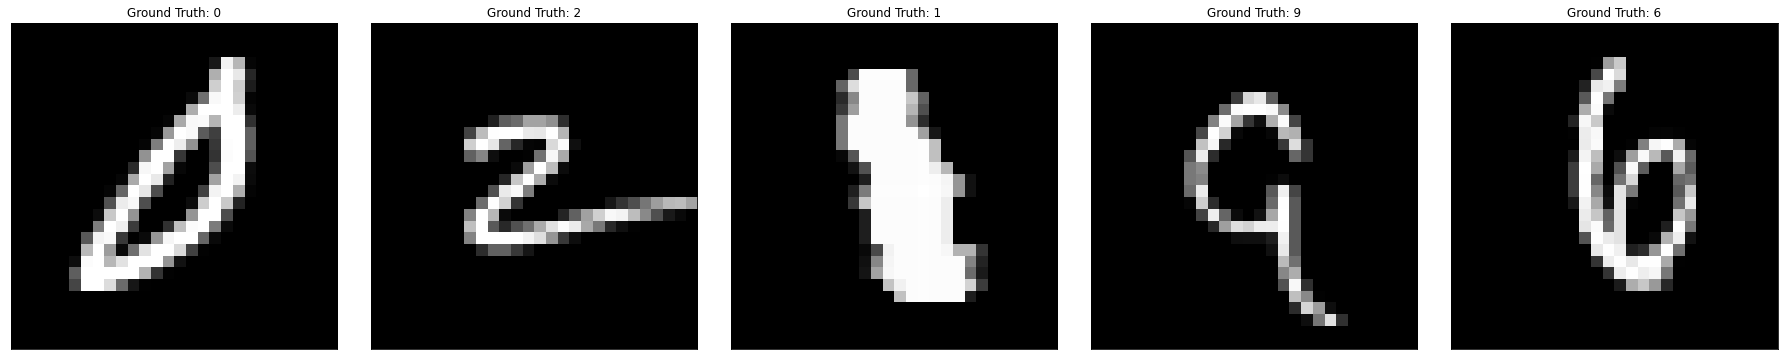

Adam train Data Size:  (160, 1, 28, 28)
Train Epoch: 1 [0/160 (0%)]	Loss: 1.064417
Train Epoch: 2 [0/160 (0%)]	Loss: 0.907513
Train Epoch: 3 [0/160 (0%)]	Loss: 1.217124
Train Epoch: 4 [0/160 (0%)]	Loss: 0.990422
Train Epoch: 5 [0/160 (0%)]	Loss: 1.035455
Train Epoch: 6 [0/160 (0%)]	Loss: 0.824460

Test set: Avg. loss: 0.5591, Accuracy: 8278/10000 (83%)



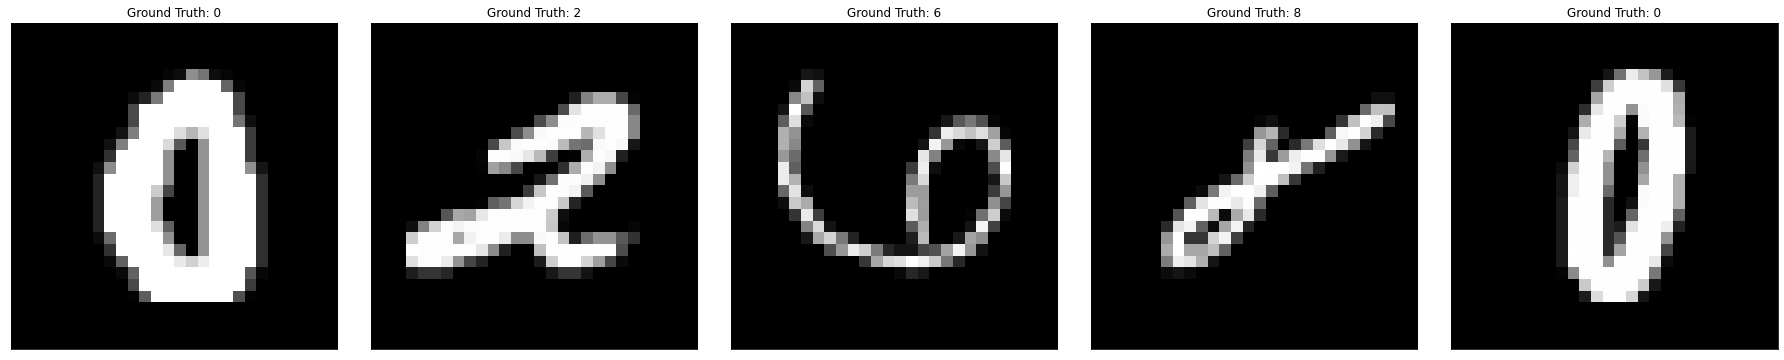

VOGN train Data Size:  (180, 1, 28, 28)
Train Epoch: 1 [0/180 (0%)]	Loss: 0.844613
Train Epoch: 2 [0/180 (0%)]	Loss: 0.786521
Train Epoch: 3 [0/180 (0%)]	Loss: 0.744960
Train Epoch: 4 [0/180 (0%)]	Loss: 0.731361
Train Epoch: 5 [0/180 (0%)]	Loss: 0.690527
Train Epoch: 6 [0/180 (0%)]	Loss: 0.695072

Test set: Avg. loss: 0.5402, Accuracy: 8291/10000 (83%)



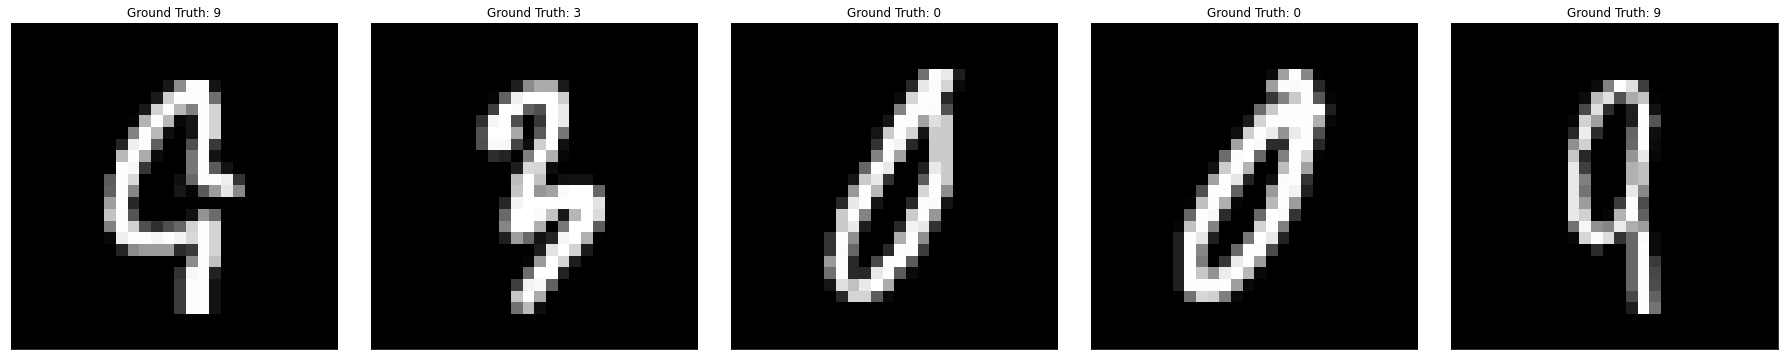

Adam train Data Size:  (180, 1, 28, 28)
Train Epoch: 1 [0/180 (0%)]	Loss: 1.100417
Train Epoch: 2 [0/180 (0%)]	Loss: 1.128575
Train Epoch: 3 [0/180 (0%)]	Loss: 1.077747
Train Epoch: 4 [0/180 (0%)]	Loss: 0.755317
Train Epoch: 5 [0/180 (0%)]	Loss: 0.810278
Train Epoch: 6 [0/180 (0%)]	Loss: 1.045826

Test set: Avg. loss: 0.5112, Accuracy: 8580/10000 (86%)



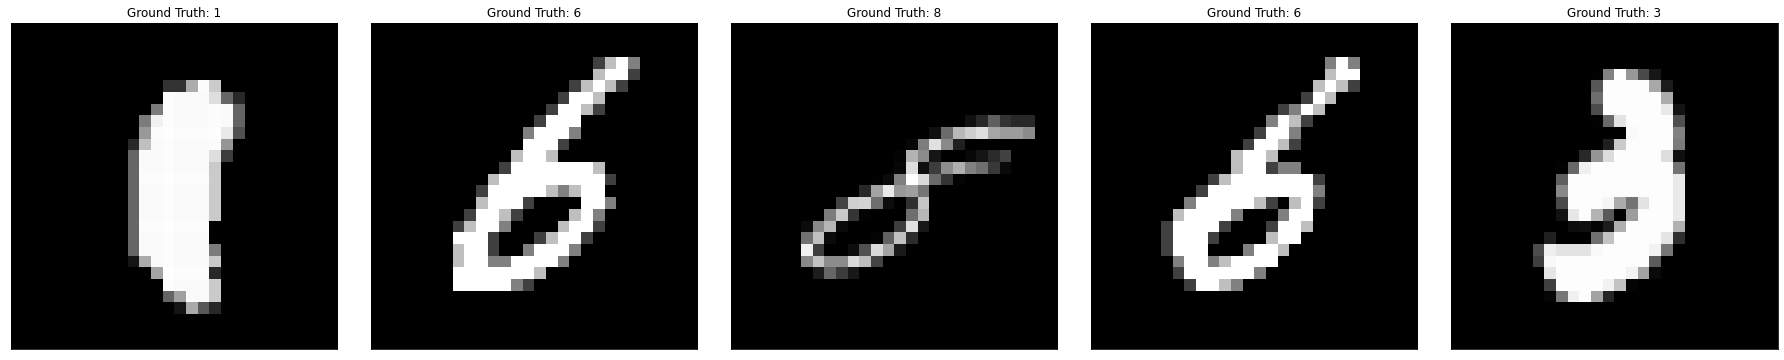

VOGN train Data Size:  (200, 1, 28, 28)
Train Epoch: 1 [0/200 (0%)]	Loss: 0.828195
Train Epoch: 2 [0/200 (0%)]	Loss: 0.807809
Train Epoch: 3 [0/200 (0%)]	Loss: 0.746686
Train Epoch: 4 [0/200 (0%)]	Loss: 0.724857
Train Epoch: 5 [0/200 (0%)]	Loss: 0.716679
Train Epoch: 6 [0/200 (0%)]	Loss: 0.644905

Test set: Avg. loss: 0.4769, Accuracy: 8512/10000 (85%)



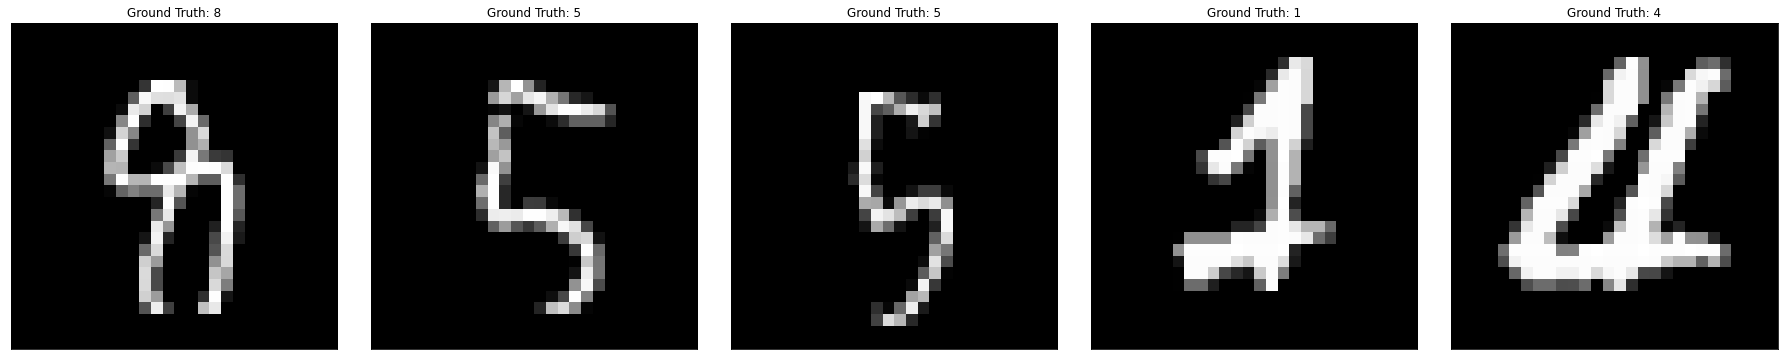

Adam train Data Size:  (200, 1, 28, 28)
Train Epoch: 1 [0/200 (0%)]	Loss: 0.765498
Train Epoch: 2 [0/200 (0%)]	Loss: 0.861838
Train Epoch: 3 [0/200 (0%)]	Loss: 0.822910
Train Epoch: 4 [0/200 (0%)]	Loss: 0.660683
Train Epoch: 5 [0/200 (0%)]	Loss: 0.981570
Train Epoch: 6 [0/200 (0%)]	Loss: 0.783381

Test set: Avg. loss: 0.5205, Accuracy: 8544/10000 (85%)



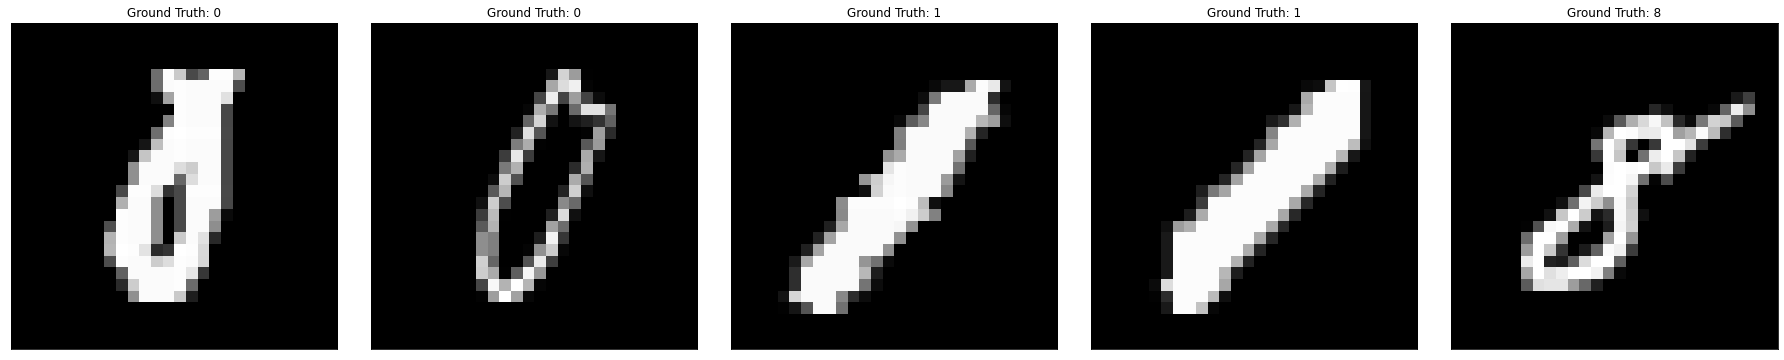

VOGN train Data Size:  (220, 1, 28, 28)
Train Epoch: 1 [0/220 (0%)]	Loss: 0.766798
Train Epoch: 2 [0/220 (0%)]	Loss: 0.744460
Train Epoch: 3 [0/220 (0%)]	Loss: 0.704394
Train Epoch: 4 [0/220 (0%)]	Loss: 0.675068
Train Epoch: 5 [0/220 (0%)]	Loss: 0.657219
Train Epoch: 6 [0/220 (0%)]	Loss: 0.636714

Test set: Avg. loss: 0.4466, Accuracy: 8645/10000 (86%)



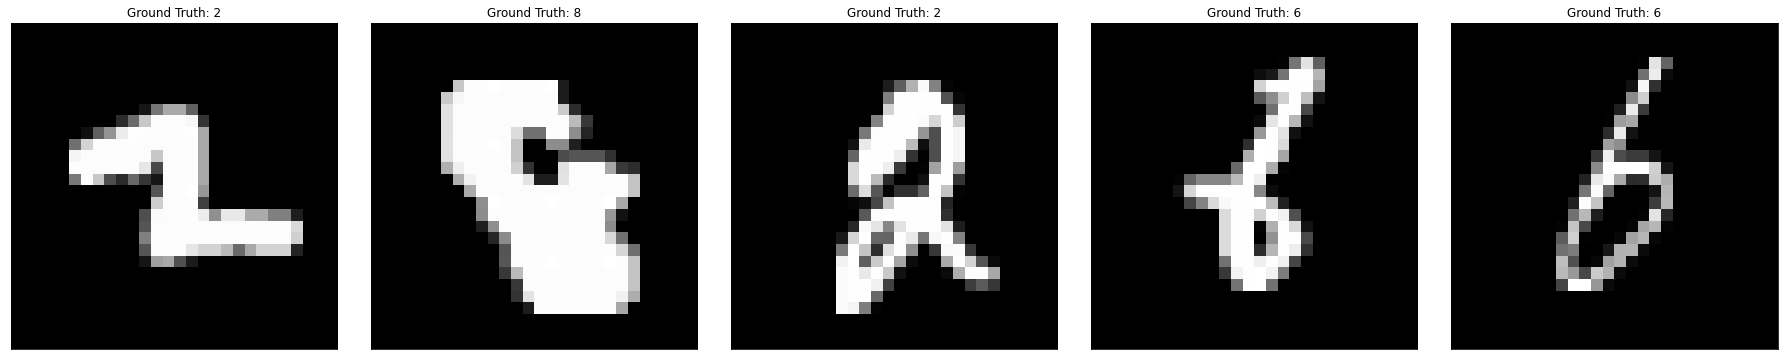

Adam train Data Size:  (220, 1, 28, 28)
Train Epoch: 1 [0/220 (0%)]	Loss: 0.715747
Train Epoch: 2 [0/220 (0%)]	Loss: 0.786480
Train Epoch: 3 [0/220 (0%)]	Loss: 0.674280
Train Epoch: 4 [0/220 (0%)]	Loss: 0.785692
Train Epoch: 5 [0/220 (0%)]	Loss: 0.698810
Train Epoch: 6 [0/220 (0%)]	Loss: 0.684224

Test set: Avg. loss: 0.4920, Accuracy: 8779/10000 (88%)



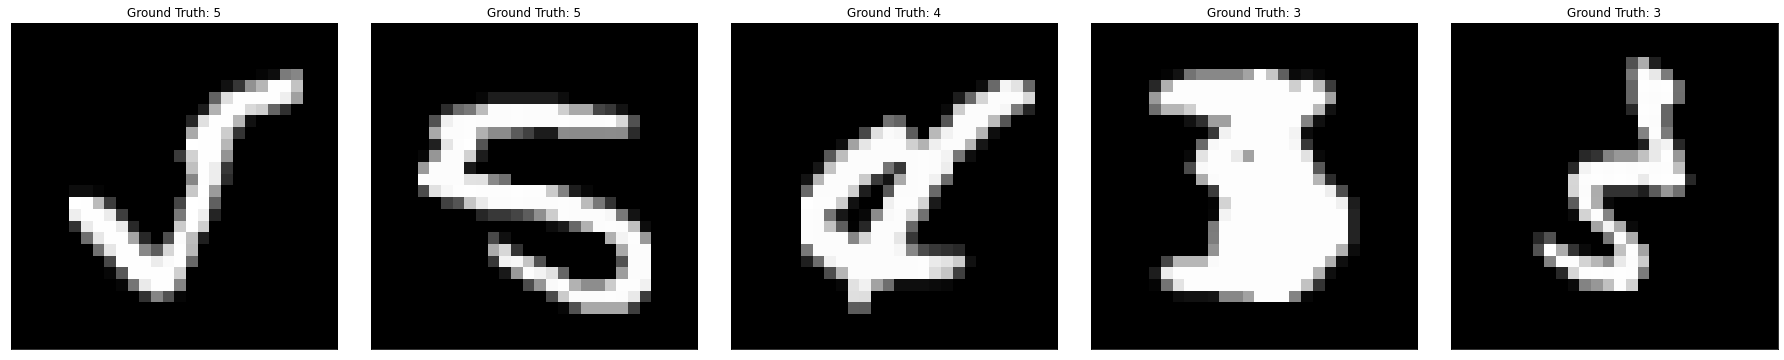

VOGN train Data Size:  (240, 1, 28, 28)
Train Epoch: 1 [0/240 (0%)]	Loss: 0.733193
Train Epoch: 2 [0/240 (0%)]	Loss: 0.689772
Train Epoch: 3 [0/240 (0%)]	Loss: 0.670415
Train Epoch: 4 [0/240 (0%)]	Loss: 0.643076
Train Epoch: 5 [0/240 (0%)]	Loss: 0.609488
Train Epoch: 6 [0/240 (0%)]	Loss: 0.565527

Test set: Avg. loss: 0.4037, Accuracy: 8772/10000 (88%)



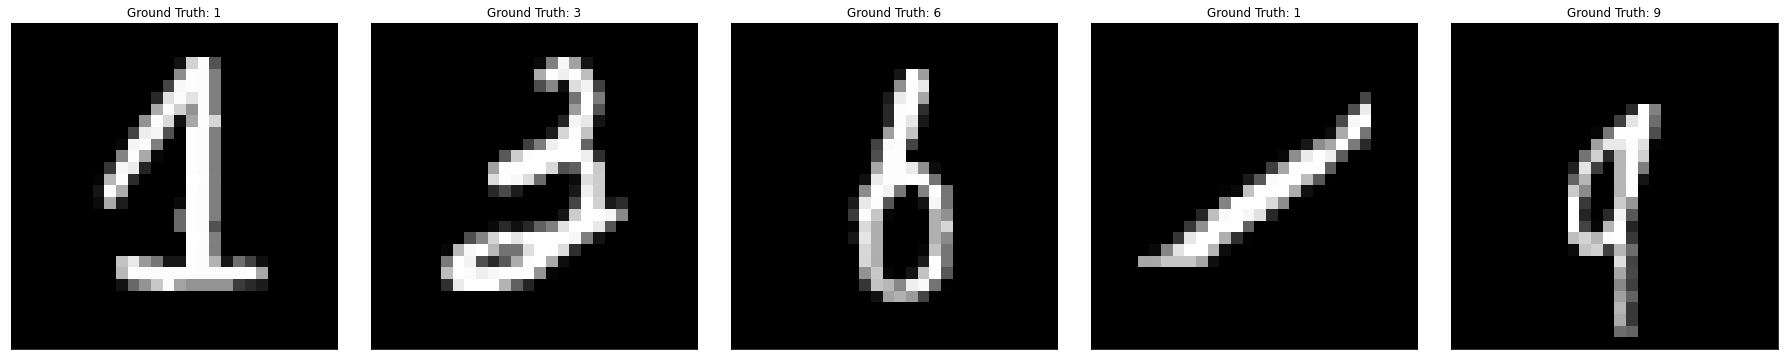

Adam train Data Size:  (240, 1, 28, 28)
Train Epoch: 1 [0/240 (0%)]	Loss: 1.127518
Train Epoch: 2 [0/240 (0%)]	Loss: 0.910052
Train Epoch: 3 [0/240 (0%)]	Loss: 0.887372
Train Epoch: 4 [0/240 (0%)]	Loss: 0.831917
Train Epoch: 5 [0/240 (0%)]	Loss: 1.034570
Train Epoch: 6 [0/240 (0%)]	Loss: 0.840410

Test set: Avg. loss: 0.4568, Accuracy: 8727/10000 (87%)



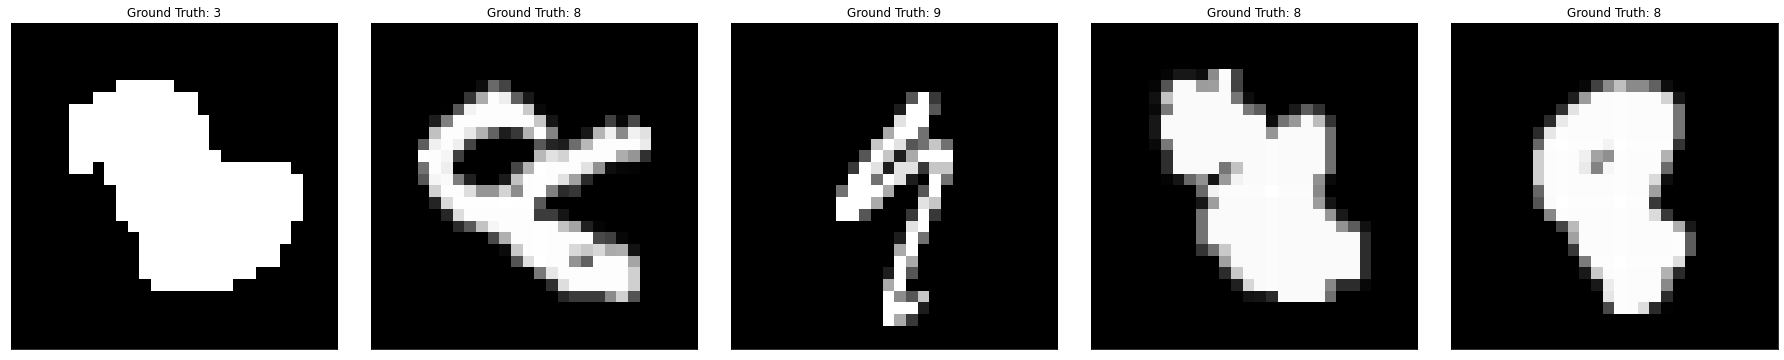

VOGN train Data Size:  (260, 1, 28, 28)
Train Epoch: 1 [0/260 (0%)]	Loss: 0.768476
Train Epoch: 2 [0/260 (0%)]	Loss: 0.726691
Train Epoch: 3 [0/260 (0%)]	Loss: 0.733977
Train Epoch: 4 [0/260 (0%)]	Loss: 0.682470
Train Epoch: 5 [0/260 (0%)]	Loss: 0.628681
Train Epoch: 6 [0/260 (0%)]	Loss: 0.627062

Test set: Avg. loss: 0.3692, Accuracy: 8881/10000 (89%)



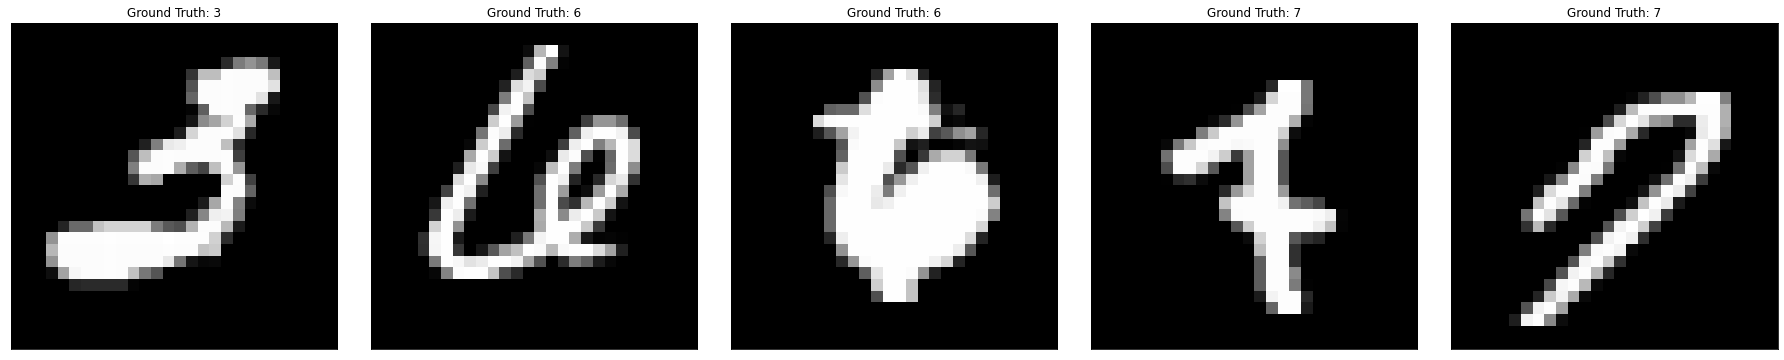

Adam train Data Size:  (260, 1, 28, 28)
Train Epoch: 1 [0/260 (0%)]	Loss: 0.794262
Train Epoch: 2 [0/260 (0%)]	Loss: 0.803638
Train Epoch: 3 [0/260 (0%)]	Loss: 0.933594
Train Epoch: 4 [0/260 (0%)]	Loss: 0.961742
Train Epoch: 5 [0/260 (0%)]	Loss: 1.086874
Train Epoch: 6 [0/260 (0%)]	Loss: 1.175110

Test set: Avg. loss: 0.4234, Accuracy: 8775/10000 (88%)



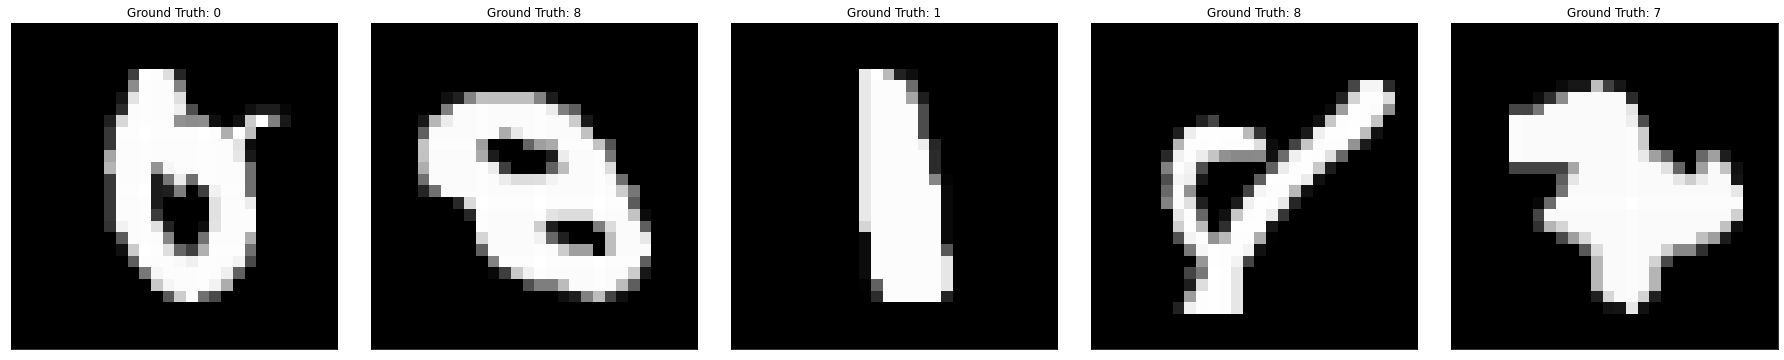

VOGN train Data Size:  (280, 1, 28, 28)
Train Epoch: 1 [0/280 (0%)]	Loss: 0.801236
Train Epoch: 2 [0/280 (0%)]	Loss: 0.768164
Train Epoch: 3 [0/280 (0%)]	Loss: 0.740032
Train Epoch: 4 [0/280 (0%)]	Loss: 0.707931
Train Epoch: 5 [0/280 (0%)]	Loss: 0.723929
Train Epoch: 6 [0/280 (0%)]	Loss: 0.675376

Test set: Avg. loss: 0.3362, Accuracy: 8991/10000 (90%)



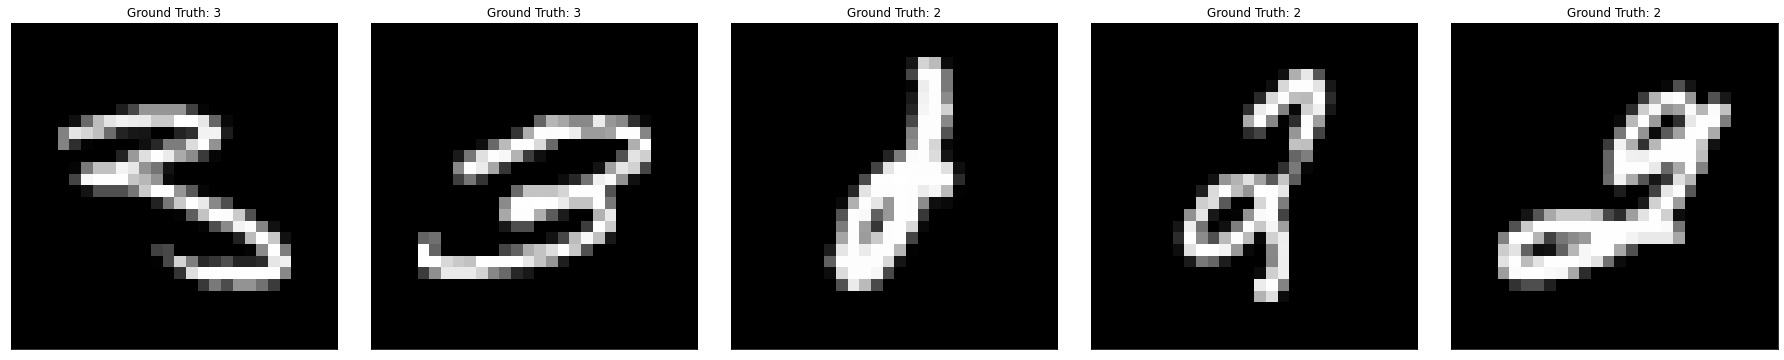

Adam train Data Size:  (280, 1, 28, 28)
Train Epoch: 1 [0/280 (0%)]	Loss: 1.232119
Train Epoch: 2 [0/280 (0%)]	Loss: 1.131698
Train Epoch: 3 [0/280 (0%)]	Loss: 1.212232
Train Epoch: 4 [0/280 (0%)]	Loss: 1.091642
Train Epoch: 5 [0/280 (0%)]	Loss: 0.866258
Train Epoch: 6 [0/280 (0%)]	Loss: 0.974515

Test set: Avg. loss: 0.3526, Accuracy: 8993/10000 (90%)



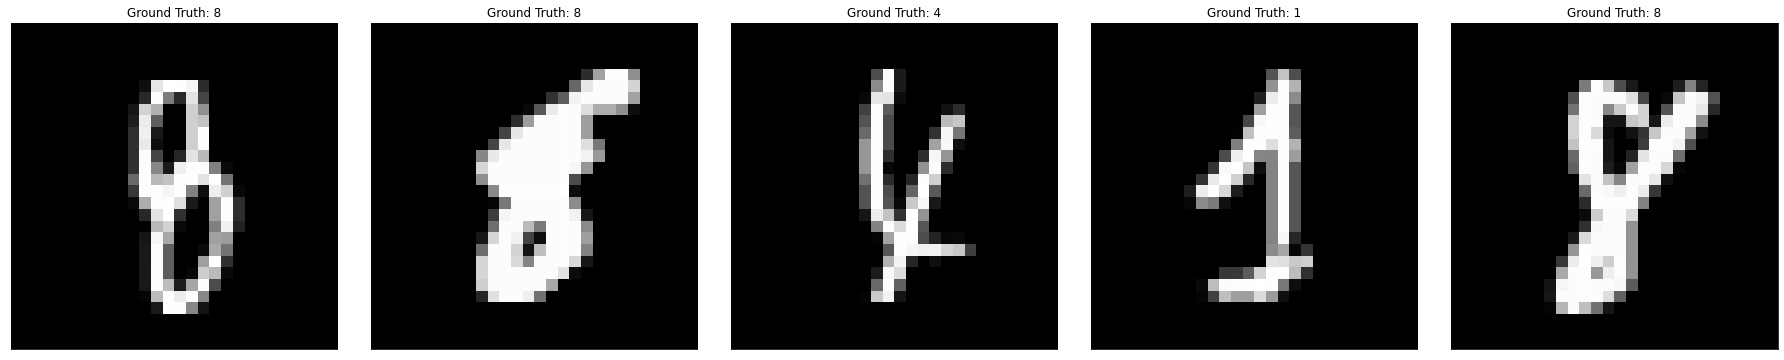

VOGN train Data Size:  (300, 1, 28, 28)
Train Epoch: 1 [0/300 (0%)]	Loss: 0.935852
Train Epoch: 2 [0/300 (0%)]	Loss: 0.886113
Train Epoch: 3 [0/300 (0%)]	Loss: 0.844618
Train Epoch: 4 [0/300 (0%)]	Loss: 0.798972
Train Epoch: 5 [0/300 (0%)]	Loss: 0.794496
Train Epoch: 6 [0/300 (0%)]	Loss: 0.762160

Test set: Avg. loss: 0.3151, Accuracy: 9062/10000 (91%)



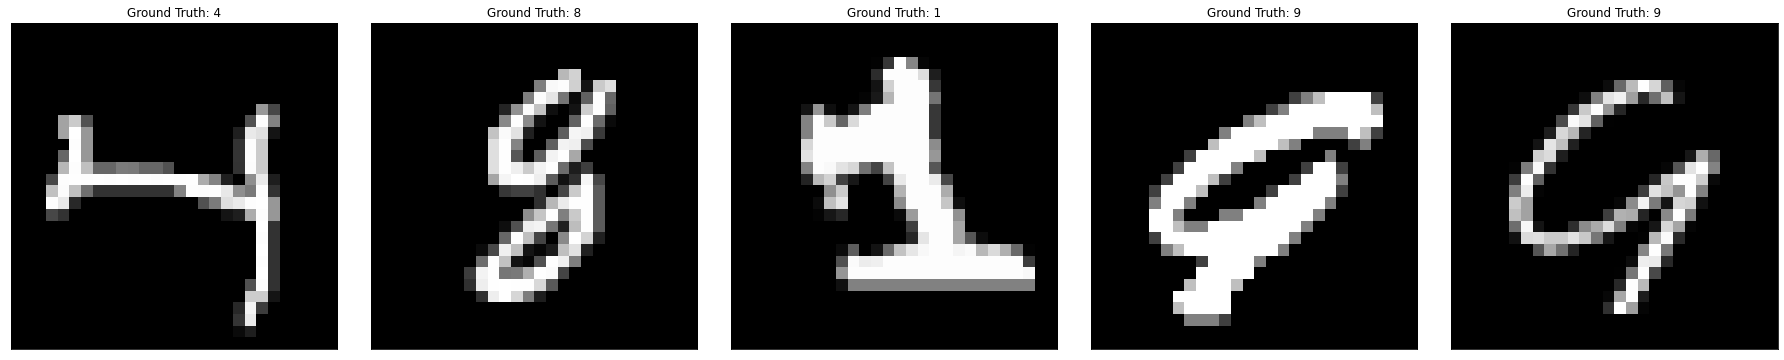

Adam train Data Size:  (300, 1, 28, 28)
Train Epoch: 1 [0/300 (0%)]	Loss: 1.044969
Train Epoch: 2 [0/300 (0%)]	Loss: 0.868260
Train Epoch: 3 [0/300 (0%)]	Loss: 0.907326
Train Epoch: 4 [0/300 (0%)]	Loss: 0.814875
Train Epoch: 5 [0/300 (0%)]	Loss: 1.038129
Train Epoch: 6 [0/300 (0%)]	Loss: 0.890378

Test set: Avg. loss: 0.3287, Accuracy: 9079/10000 (91%)



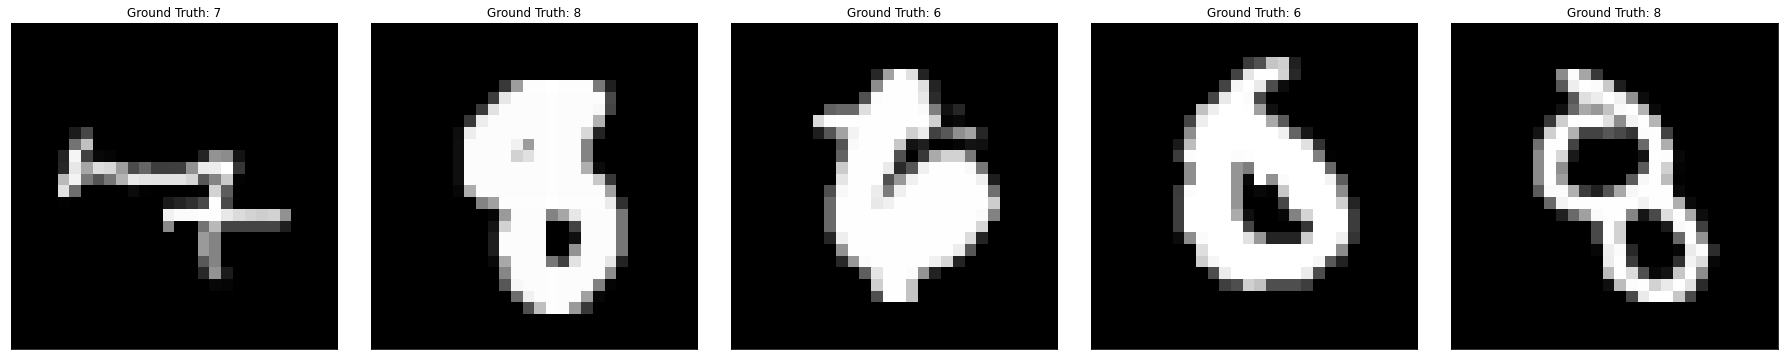

VOGN train Data Size:  (320, 1, 28, 28)
Train Epoch: 1 [0/320 (0%)]	Loss: 0.933985
Train Epoch: 2 [0/320 (0%)]	Loss: 0.877614
Train Epoch: 3 [0/320 (0%)]	Loss: 0.830345
Train Epoch: 4 [0/320 (0%)]	Loss: 0.832904
Train Epoch: 5 [0/320 (0%)]	Loss: 0.784650
Train Epoch: 6 [0/320 (0%)]	Loss: 0.794047

Test set: Avg. loss: 0.2943, Accuracy: 9121/10000 (91%)



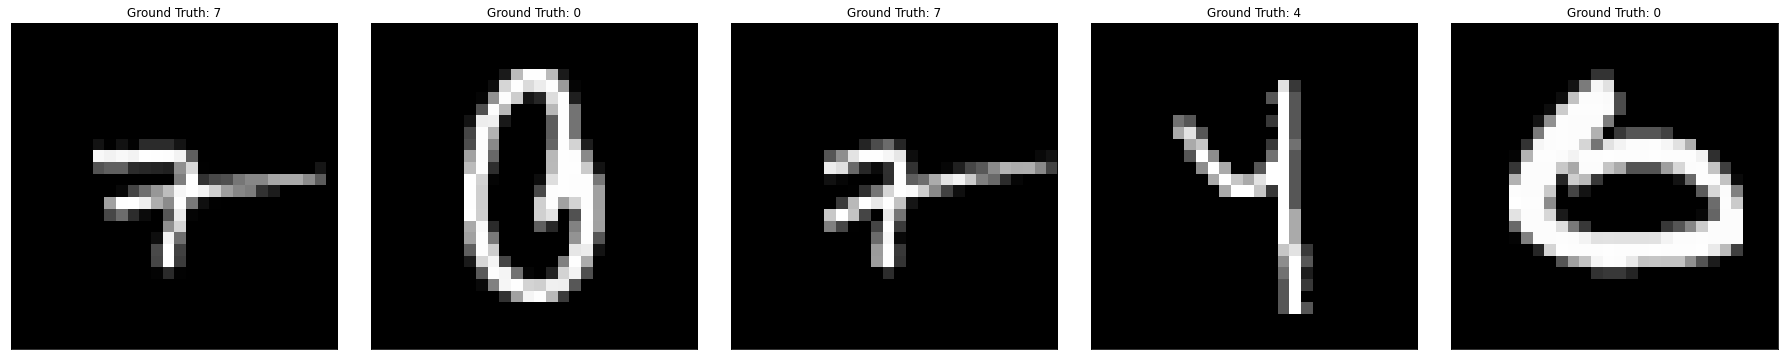

Adam train Data Size:  (320, 1, 28, 28)
Train Epoch: 1 [0/320 (0%)]	Loss: 1.110716
Train Epoch: 2 [0/320 (0%)]	Loss: 0.902508
Train Epoch: 3 [0/320 (0%)]	Loss: 0.937264
Train Epoch: 4 [0/320 (0%)]	Loss: 0.847496
Train Epoch: 5 [0/320 (0%)]	Loss: 1.085757
Train Epoch: 6 [0/320 (0%)]	Loss: 1.002297

Test set: Avg. loss: 0.3402, Accuracy: 9019/10000 (90%)



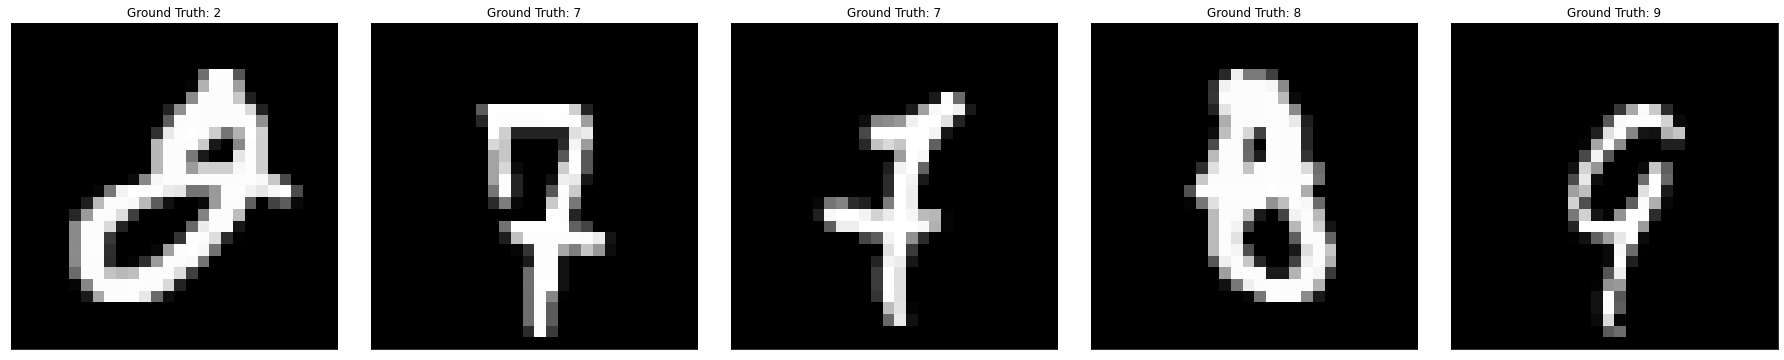

VOGN train Data Size:  (340, 1, 28, 28)
Train Epoch: 1 [0/340 (0%)]	Loss: 0.935902
Train Epoch: 2 [0/340 (0%)]	Loss: 0.888013
Train Epoch: 3 [0/340 (0%)]	Loss: 0.893260
Train Epoch: 4 [0/340 (0%)]	Loss: 0.843681
Train Epoch: 5 [0/340 (0%)]	Loss: 0.835800
Train Epoch: 6 [0/340 (0%)]	Loss: 0.793907

Test set: Avg. loss: 0.2834, Accuracy: 9128/10000 (91%)



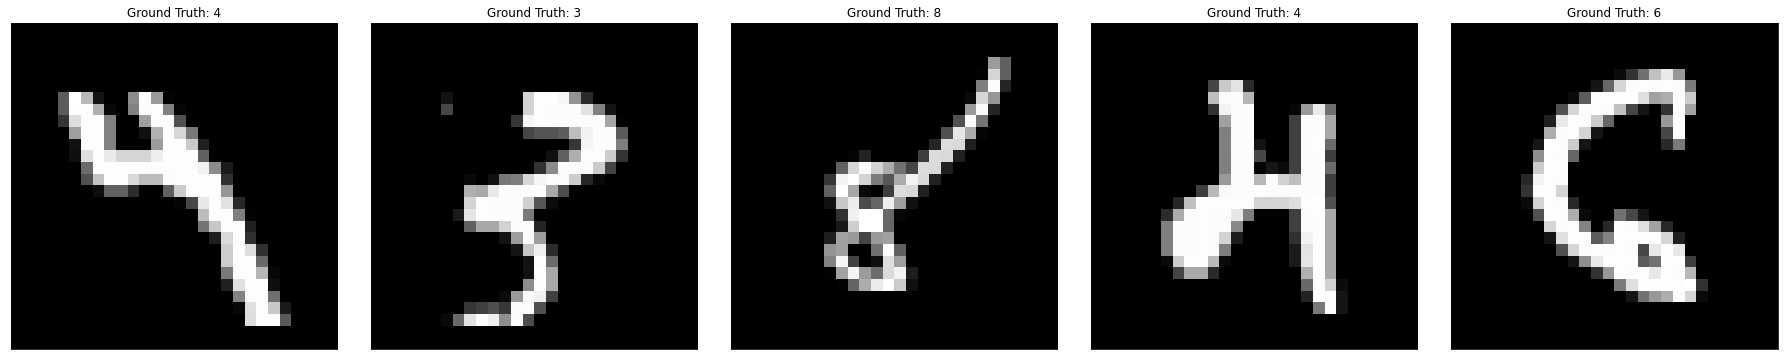

Adam train Data Size:  (340, 1, 28, 28)
Train Epoch: 1 [0/340 (0%)]	Loss: 1.024288
Train Epoch: 2 [0/340 (0%)]	Loss: 1.063903
Train Epoch: 3 [0/340 (0%)]	Loss: 0.966741
Train Epoch: 4 [0/340 (0%)]	Loss: 1.064380
Train Epoch: 5 [0/340 (0%)]	Loss: 1.062624
Train Epoch: 6 [0/340 (0%)]	Loss: 1.000616

Test set: Avg. loss: 0.3317, Accuracy: 9053/10000 (91%)



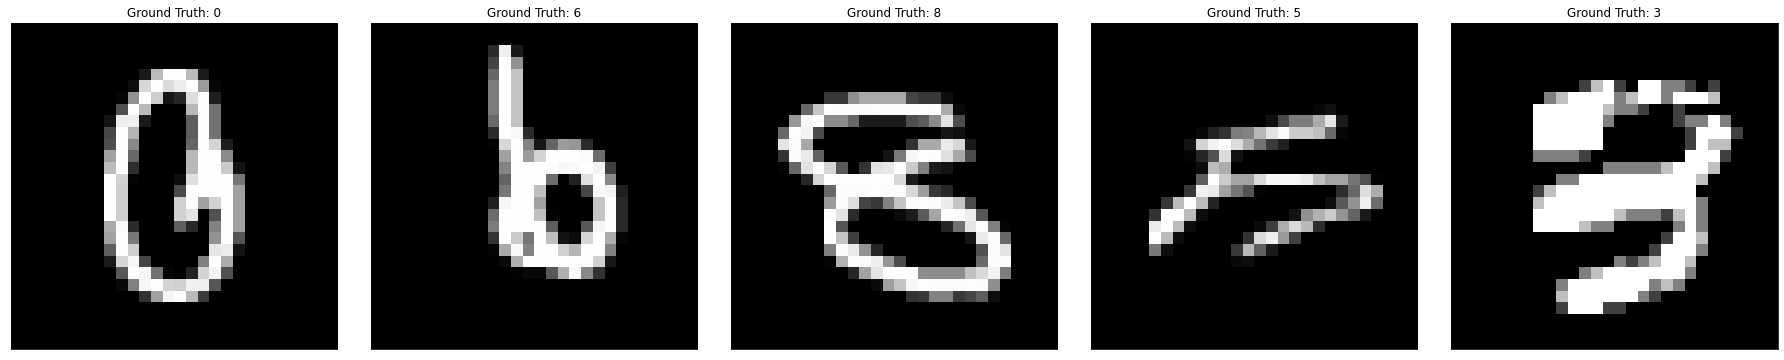

VOGN train Data Size:  (360, 1, 28, 28)
Train Epoch: 1 [0/360 (0%)]	Loss: 0.889695
Train Epoch: 2 [0/360 (0%)]	Loss: 0.893226
Train Epoch: 3 [0/360 (0%)]	Loss: 0.868245
Train Epoch: 4 [0/360 (0%)]	Loss: 0.805062
Train Epoch: 5 [0/360 (0%)]	Loss: 0.821588
Train Epoch: 6 [0/360 (0%)]	Loss: 0.789026

Test set: Avg. loss: 0.2705, Accuracy: 9171/10000 (92%)



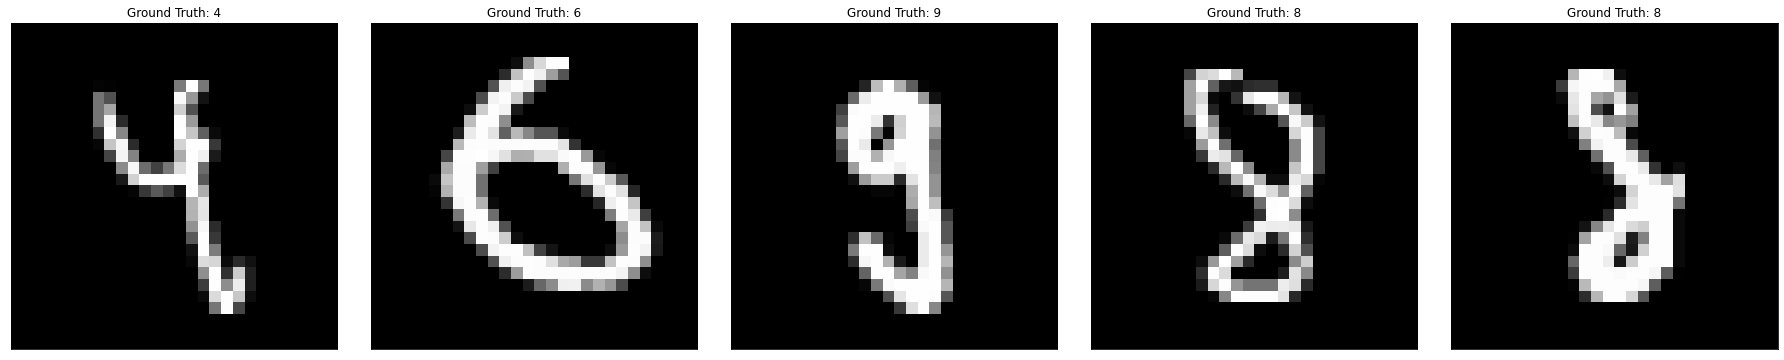

Adam train Data Size:  (360, 1, 28, 28)
Train Epoch: 1 [0/360 (0%)]	Loss: 1.185668
Train Epoch: 2 [0/360 (0%)]	Loss: 0.809990
Train Epoch: 3 [0/360 (0%)]	Loss: 0.914377
Train Epoch: 4 [0/360 (0%)]	Loss: 0.804416
Train Epoch: 5 [0/360 (0%)]	Loss: 1.056498
Train Epoch: 6 [0/360 (0%)]	Loss: 0.894889

Test set: Avg. loss: 0.2825, Accuracy: 9225/10000 (92%)



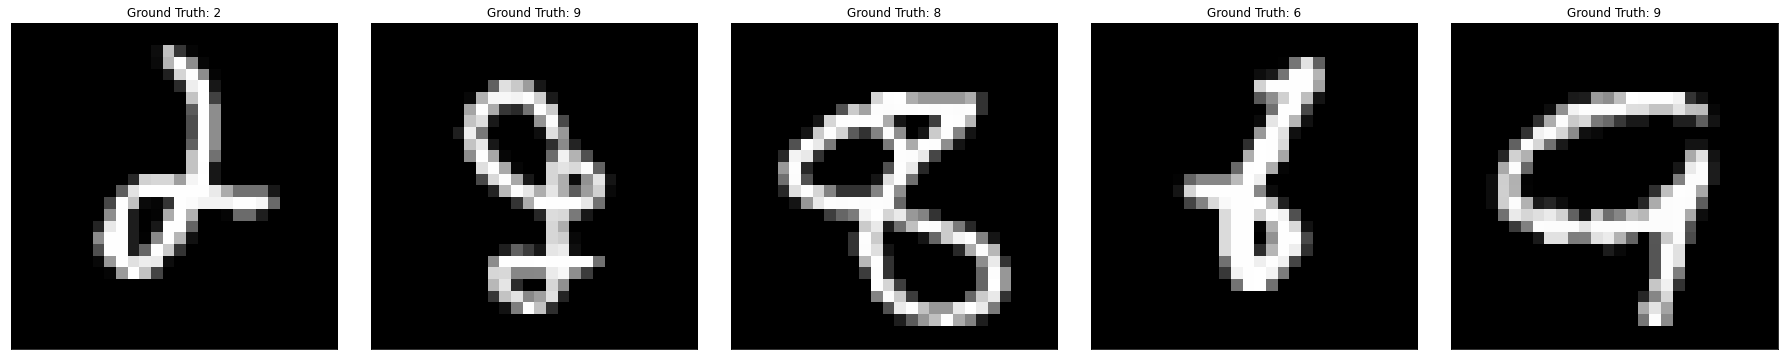

VOGN train Data Size:  (380, 1, 28, 28)
Train Epoch: 1 [0/380 (0%)]	Loss: 0.849723
Train Epoch: 2 [0/380 (0%)]	Loss: 0.855869
Train Epoch: 3 [0/380 (0%)]	Loss: 0.826087
Train Epoch: 4 [0/380 (0%)]	Loss: 0.810558
Train Epoch: 5 [0/380 (0%)]	Loss: 0.797680
Train Epoch: 6 [0/380 (0%)]	Loss: 0.725840

Test set: Avg. loss: 0.2631, Accuracy: 9181/10000 (92%)



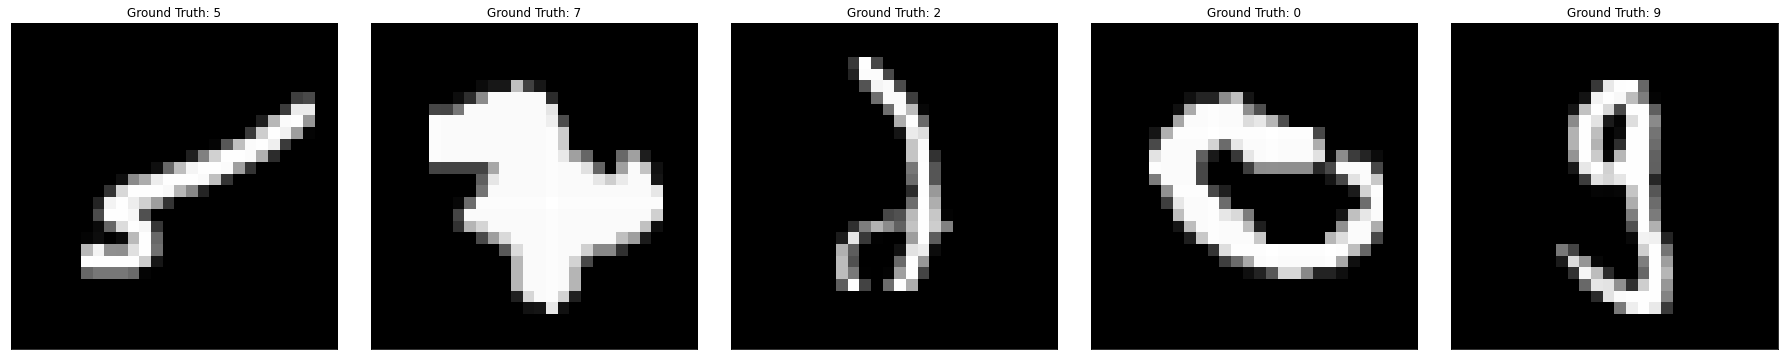

Adam train Data Size:  (380, 1, 28, 28)
Train Epoch: 1 [0/380 (0%)]	Loss: 0.828206
Train Epoch: 2 [0/380 (0%)]	Loss: 1.218335
Train Epoch: 3 [0/380 (0%)]	Loss: 0.736560
Train Epoch: 4 [0/380 (0%)]	Loss: 0.990320
Train Epoch: 5 [0/380 (0%)]	Loss: 0.798823
Train Epoch: 6 [0/380 (0%)]	Loss: 0.930901

Test set: Avg. loss: 0.2938, Accuracy: 9238/10000 (92%)



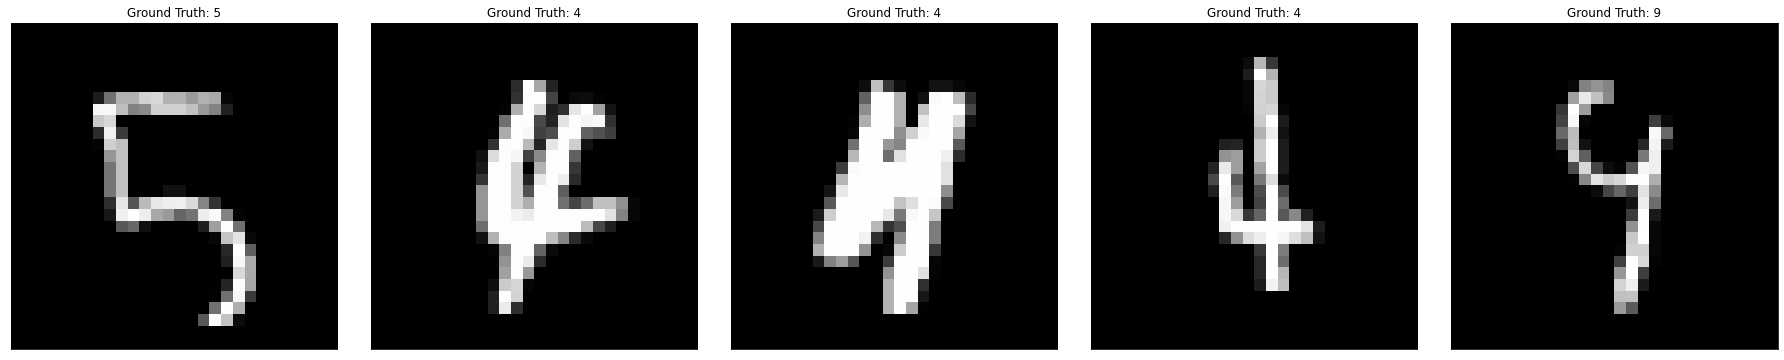

VOGN train Data Size:  (400, 1, 28, 28)
Train Epoch: 1 [0/400 (0%)]	Loss: 0.835960
Train Epoch: 2 [0/400 (0%)]	Loss: 0.802876
Train Epoch: 3 [0/400 (0%)]	Loss: 0.787150
Train Epoch: 4 [0/400 (0%)]	Loss: 0.753910
Train Epoch: 5 [0/400 (0%)]	Loss: 0.761669
Train Epoch: 6 [0/400 (0%)]	Loss: 0.753475

Test set: Avg. loss: 0.2477, Accuracy: 9230/10000 (92%)



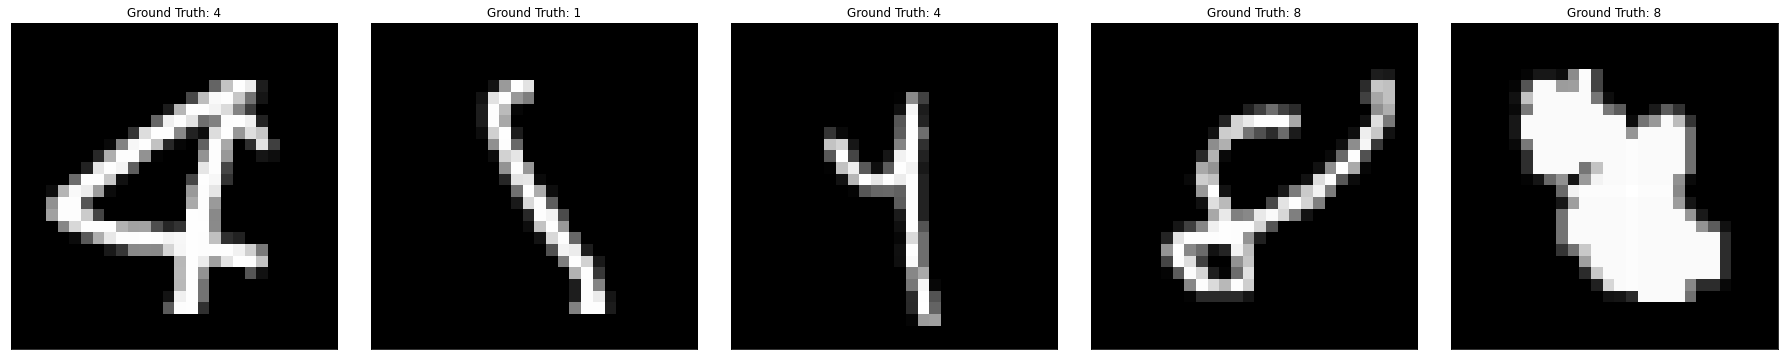

Adam train Data Size:  (400, 1, 28, 28)
Train Epoch: 1 [0/400 (0%)]	Loss: 0.928746
Train Epoch: 2 [0/400 (0%)]	Loss: 0.826805
Train Epoch: 3 [0/400 (0%)]	Loss: 0.617040
Train Epoch: 4 [0/400 (0%)]	Loss: 0.916913
Train Epoch: 5 [0/400 (0%)]	Loss: 0.974990
Train Epoch: 6 [0/400 (0%)]	Loss: 0.819365

Test set: Avg. loss: 0.2926, Accuracy: 9154/10000 (92%)



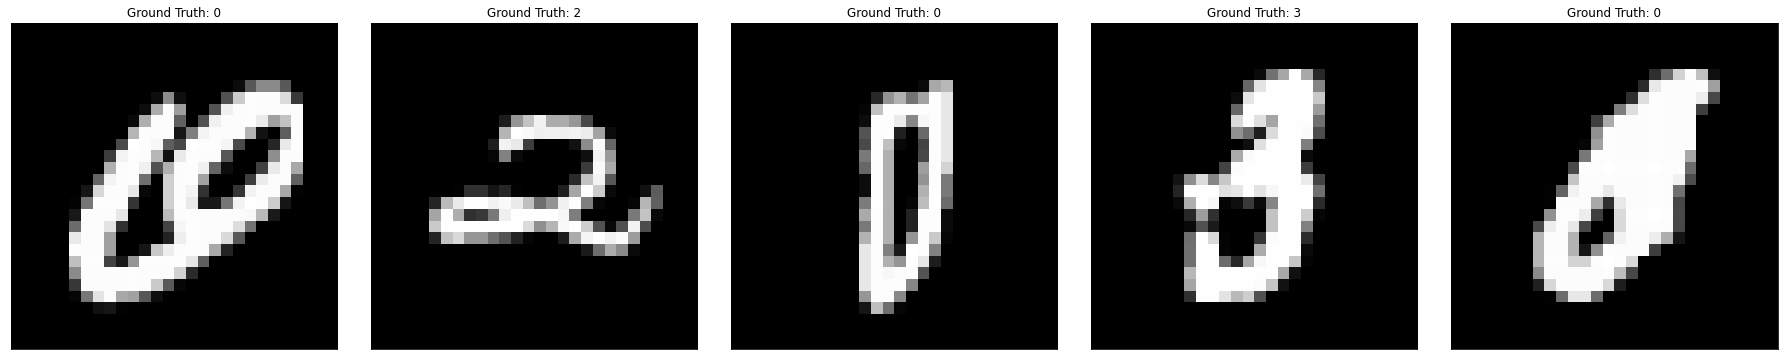

VOGN train Data Size:  (420, 1, 28, 28)
Train Epoch: 1 [0/420 (0%)]	Loss: 0.808978
Train Epoch: 2 [0/420 (0%)]	Loss: 0.758423
Train Epoch: 3 [0/420 (0%)]	Loss: 0.752011
Train Epoch: 4 [0/420 (0%)]	Loss: 0.757665
Train Epoch: 5 [0/420 (0%)]	Loss: 0.724615
Train Epoch: 6 [0/420 (0%)]	Loss: 0.720112

Test set: Avg. loss: 0.2447, Accuracy: 9232/10000 (92%)



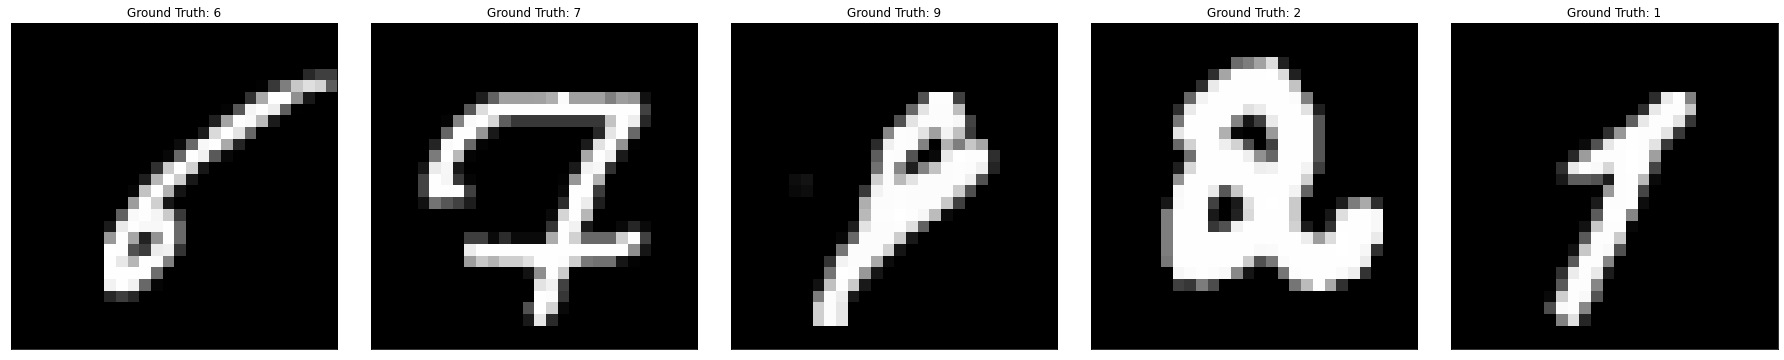

Adam train Data Size:  (420, 1, 28, 28)
Train Epoch: 1 [0/420 (0%)]	Loss: 0.857346
Train Epoch: 2 [0/420 (0%)]	Loss: 0.618919
Train Epoch: 3 [0/420 (0%)]	Loss: 0.860956
Train Epoch: 4 [0/420 (0%)]	Loss: 0.617028
Train Epoch: 5 [0/420 (0%)]	Loss: 0.763495
Train Epoch: 6 [0/420 (0%)]	Loss: 0.851859

Test set: Avg. loss: 0.3159, Accuracy: 8985/10000 (90%)



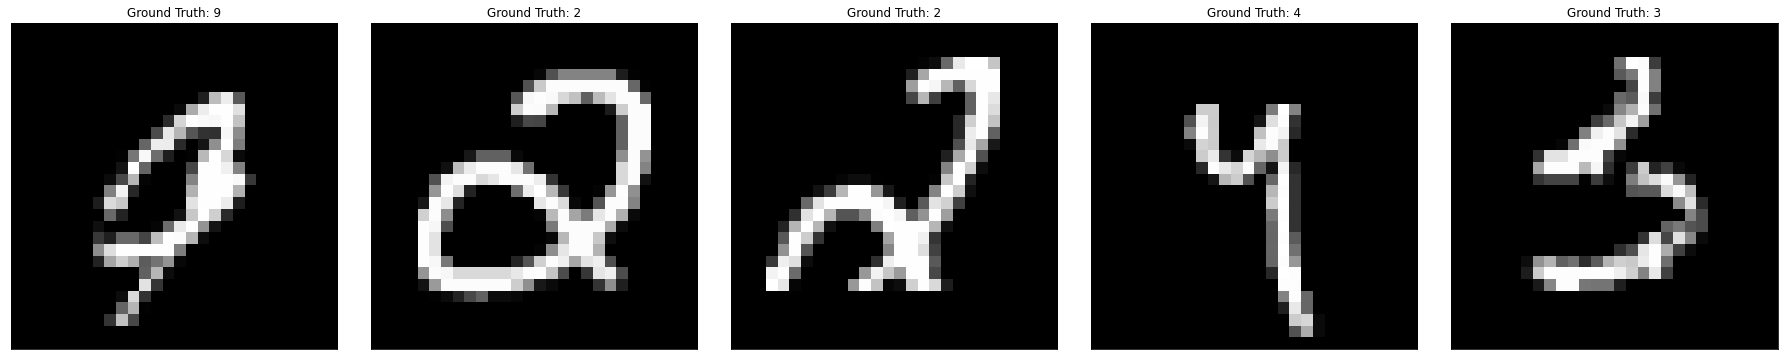

VOGN train Data Size:  (440, 1, 28, 28)
Train Epoch: 1 [0/440 (0%)]	Loss: 0.768261
Train Epoch: 2 [0/440 (0%)]	Loss: 0.756402
Train Epoch: 3 [0/440 (0%)]	Loss: 0.770112
Train Epoch: 4 [0/440 (0%)]	Loss: 0.756027
Train Epoch: 5 [0/440 (0%)]	Loss: 0.735810
Train Epoch: 6 [0/440 (0%)]	Loss: 0.700338

Test set: Avg. loss: 0.2287, Accuracy: 9277/10000 (93%)



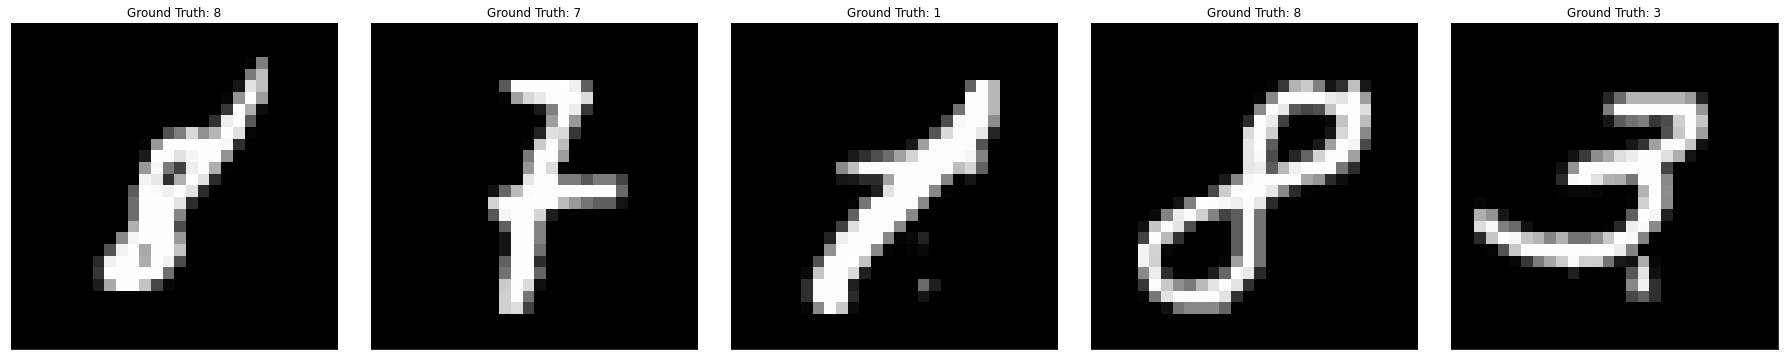

Adam train Data Size:  (440, 1, 28, 28)
Train Epoch: 1 [0/440 (0%)]	Loss: 0.814571
Train Epoch: 2 [0/440 (0%)]	Loss: 0.892411
Train Epoch: 3 [0/440 (0%)]	Loss: 0.864628
Train Epoch: 4 [0/440 (0%)]	Loss: 0.818583
Train Epoch: 5 [0/440 (0%)]	Loss: 0.681029
Train Epoch: 6 [0/440 (0%)]	Loss: 0.749079

Test set: Avg. loss: 0.2691, Accuracy: 9229/10000 (92%)



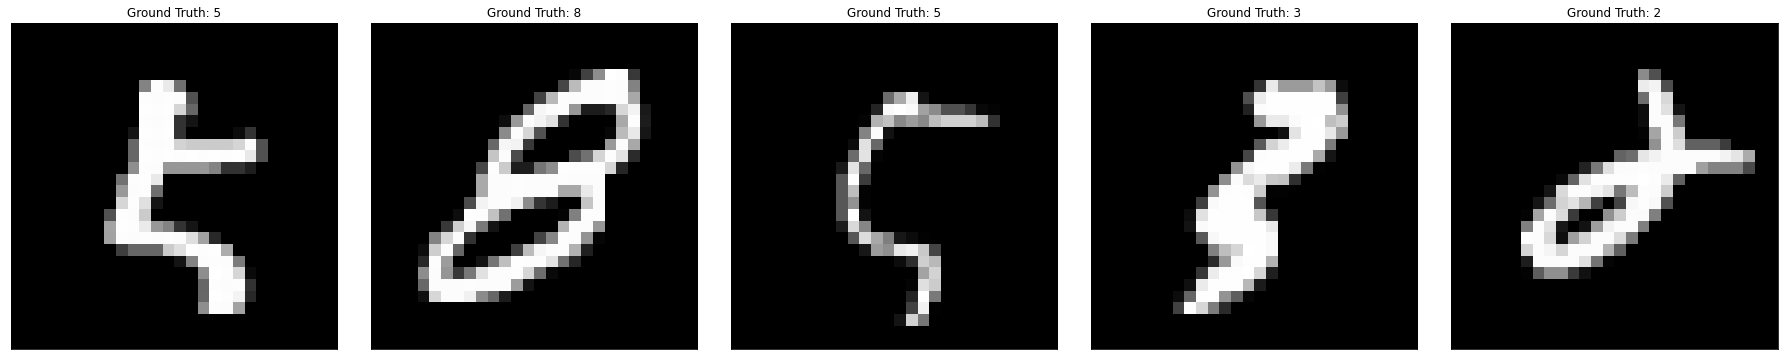

VOGN train Data Size:  (460, 1, 28, 28)
Train Epoch: 1 [0/460 (0%)]	Loss: 0.732199
Train Epoch: 2 [0/460 (0%)]	Loss: 0.710538
Train Epoch: 3 [0/460 (0%)]	Loss: 0.714718
Train Epoch: 4 [0/460 (0%)]	Loss: 0.729649
Train Epoch: 5 [0/460 (0%)]	Loss: 0.695640
Train Epoch: 6 [0/460 (0%)]	Loss: 0.694304

Test set: Avg. loss: 0.2153, Accuracy: 9325/10000 (93%)



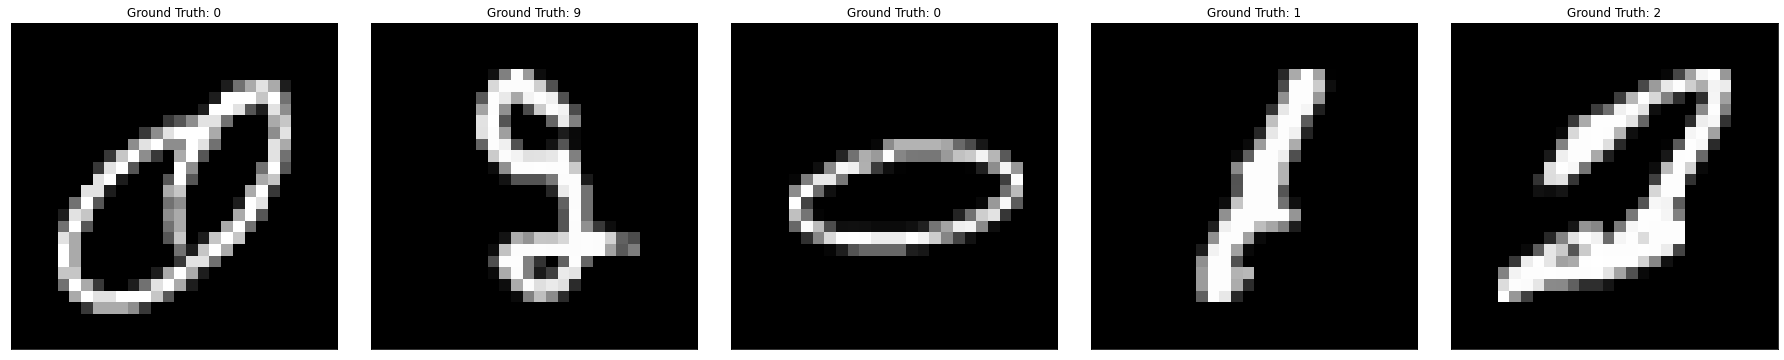

Adam train Data Size:  (460, 1, 28, 28)
Train Epoch: 1 [0/460 (0%)]	Loss: 0.801319
Train Epoch: 2 [0/460 (0%)]	Loss: 0.821255
Train Epoch: 3 [0/460 (0%)]	Loss: 0.979319
Train Epoch: 4 [0/460 (0%)]	Loss: 0.695568
Train Epoch: 5 [0/460 (0%)]	Loss: 0.580526
Train Epoch: 6 [0/460 (0%)]	Loss: 0.948454

Test set: Avg. loss: 0.2517, Accuracy: 9258/10000 (93%)



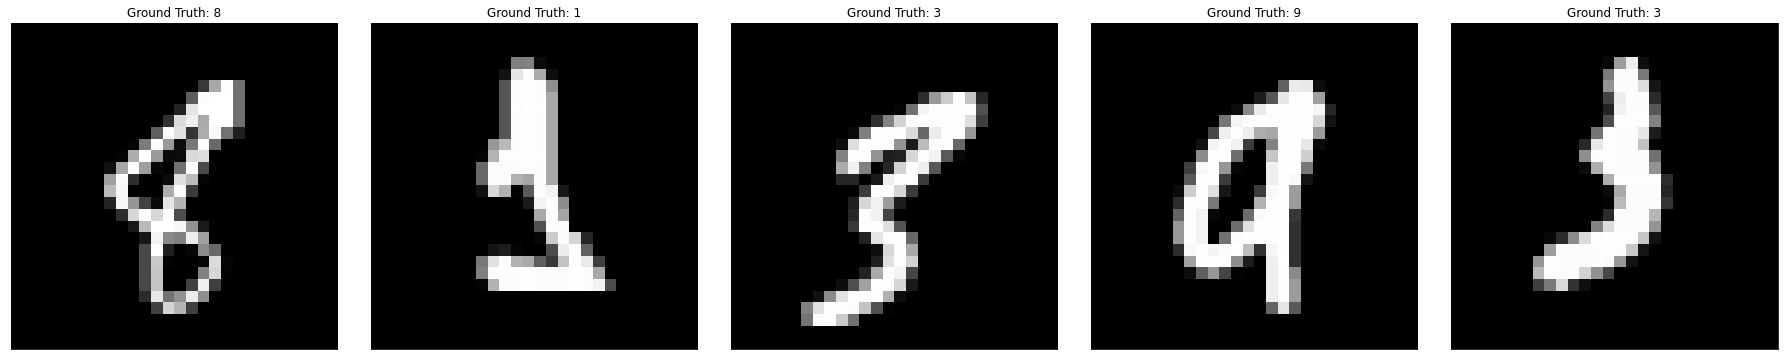

VOGN train Data Size:  (480, 1, 28, 28)
Train Epoch: 1 [0/480 (0%)]	Loss: 0.694971
Train Epoch: 2 [0/480 (0%)]	Loss: 0.681310
Train Epoch: 3 [0/480 (0%)]	Loss: 0.633515
Train Epoch: 4 [0/480 (0%)]	Loss: 0.645701
Train Epoch: 5 [0/480 (0%)]	Loss: 0.666373
Train Epoch: 6 [0/480 (0%)]	Loss: 0.650496

Test set: Avg. loss: 0.2041, Accuracy: 9355/10000 (94%)



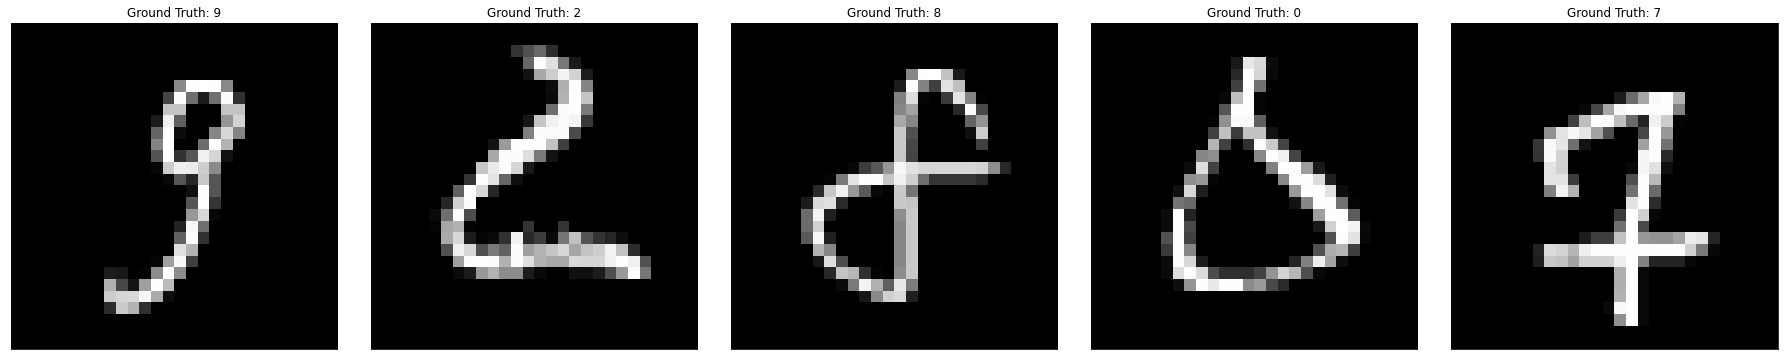

Adam train Data Size:  (480, 1, 28, 28)
Train Epoch: 1 [0/480 (0%)]	Loss: 0.940483
Train Epoch: 2 [0/480 (0%)]	Loss: 0.914778
Train Epoch: 3 [0/480 (0%)]	Loss: 0.804965
Train Epoch: 4 [0/480 (0%)]	Loss: 0.947307
Train Epoch: 5 [0/480 (0%)]	Loss: 0.801990
Train Epoch: 6 [0/480 (0%)]	Loss: 0.687021

Test set: Avg. loss: 0.2625, Accuracy: 9225/10000 (92%)



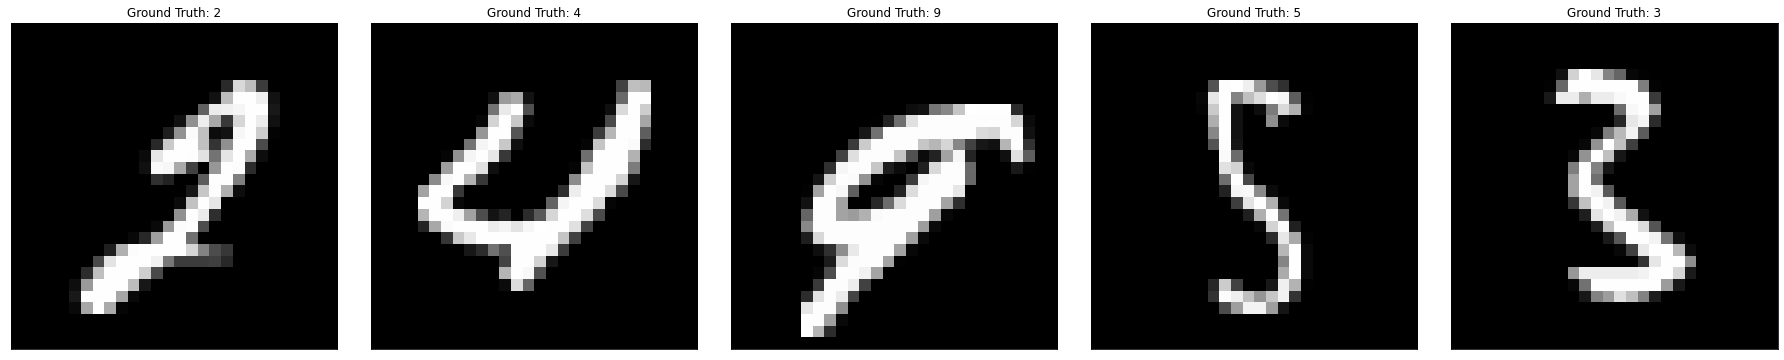

VOGN train Data Size:  (500, 1, 28, 28)
Train Epoch: 1 [0/500 (0%)]	Loss: 0.745714
Train Epoch: 2 [0/500 (0%)]	Loss: 0.765117
Train Epoch: 3 [0/500 (0%)]	Loss: 0.763112
Train Epoch: 4 [0/500 (0%)]	Loss: 0.736100
Train Epoch: 5 [0/500 (0%)]	Loss: 0.718793
Train Epoch: 6 [0/500 (0%)]	Loss: 0.708922

Test set: Avg. loss: 0.2036, Accuracy: 9360/10000 (94%)



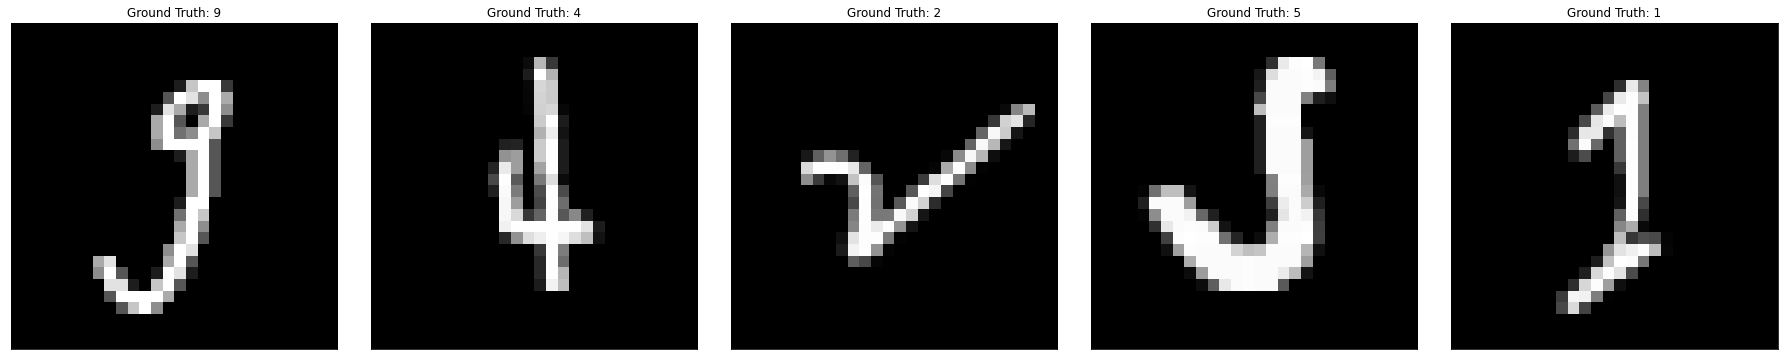

Adam train Data Size:  (500, 1, 28, 28)
Train Epoch: 1 [0/500 (0%)]	Loss: 0.934275
Train Epoch: 2 [0/500 (0%)]	Loss: 0.884513
Train Epoch: 3 [0/500 (0%)]	Loss: 0.684233
Train Epoch: 4 [0/500 (0%)]	Loss: 0.858882
Train Epoch: 5 [0/500 (0%)]	Loss: 0.705213
Train Epoch: 6 [0/500 (0%)]	Loss: 0.696132

Test set: Avg. loss: 0.2627, Accuracy: 9265/10000 (93%)



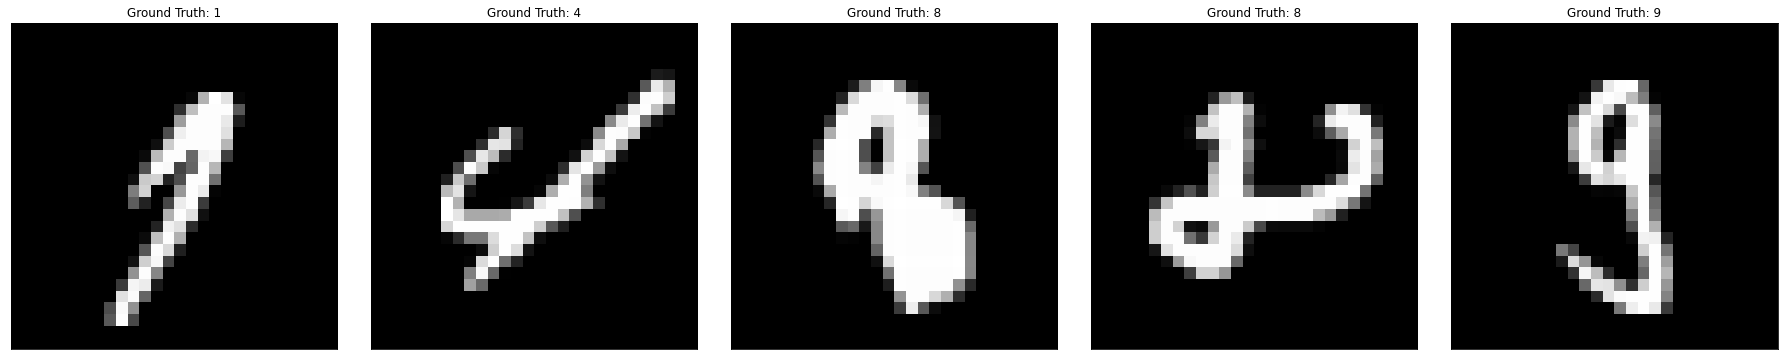

VOGN train Data Size:  (520, 1, 28, 28)
Train Epoch: 1 [0/520 (0%)]	Loss: 0.770087
Train Epoch: 2 [0/520 (0%)]	Loss: 0.759823
Train Epoch: 3 [0/520 (0%)]	Loss: 0.759109
Train Epoch: 4 [0/520 (0%)]	Loss: 0.731061
Train Epoch: 5 [0/520 (0%)]	Loss: 0.720230
Train Epoch: 6 [0/520 (0%)]	Loss: 0.717444

Test set: Avg. loss: 0.1929, Accuracy: 9401/10000 (94%)



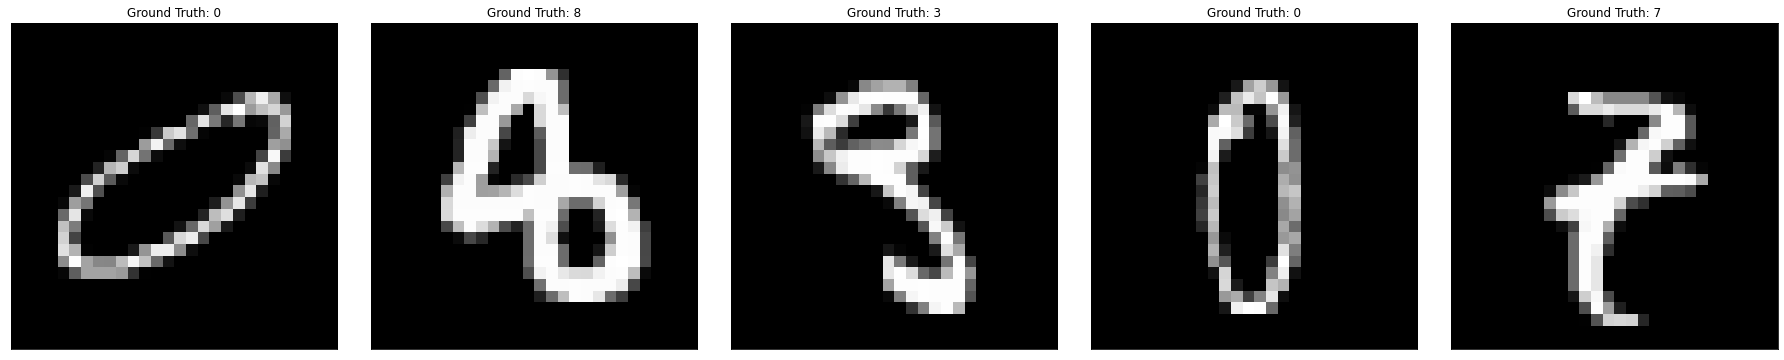

Adam train Data Size:  (520, 1, 28, 28)
Train Epoch: 1 [0/520 (0%)]	Loss: 0.872232
Train Epoch: 2 [0/520 (0%)]	Loss: 0.864228
Train Epoch: 3 [0/520 (0%)]	Loss: 1.171767
Train Epoch: 4 [0/520 (0%)]	Loss: 0.737958
Train Epoch: 5 [0/520 (0%)]	Loss: 0.952901
Train Epoch: 6 [0/520 (0%)]	Loss: 0.939176

Test set: Avg. loss: 0.2522, Accuracy: 9208/10000 (92%)



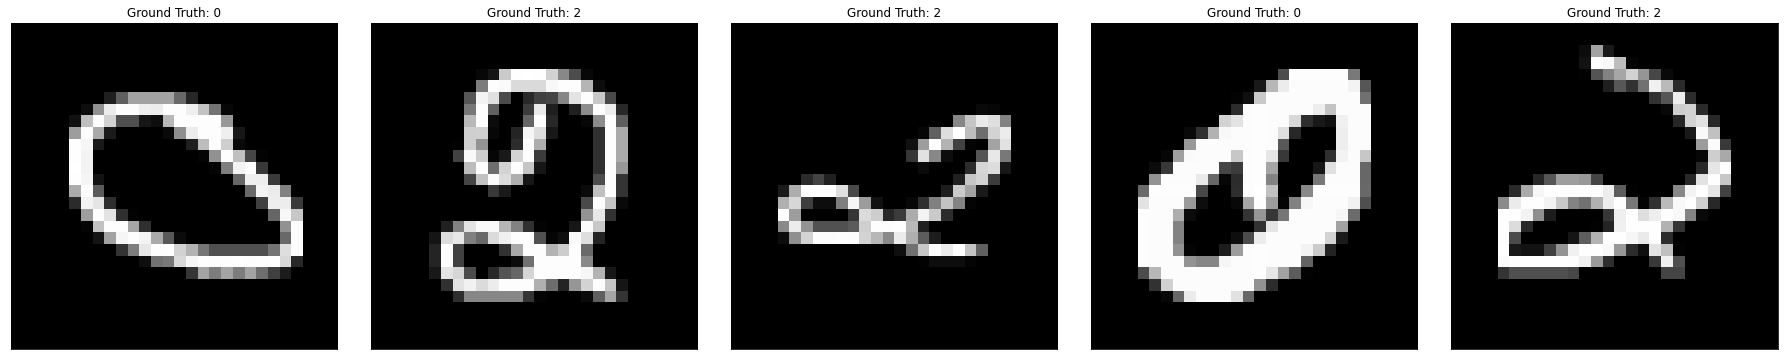

VOGN train Data Size:  (540, 1, 28, 28)
Train Epoch: 1 [0/540 (0%)]	Loss: 0.727613
Train Epoch: 2 [0/540 (0%)]	Loss: 0.753402
Train Epoch: 3 [0/540 (0%)]	Loss: 0.743548
Train Epoch: 4 [0/540 (0%)]	Loss: 0.745656
Train Epoch: 5 [0/540 (0%)]	Loss: 0.716507
Train Epoch: 6 [0/540 (0%)]	Loss: 0.710587

Test set: Avg. loss: 0.1867, Accuracy: 9428/10000 (94%)



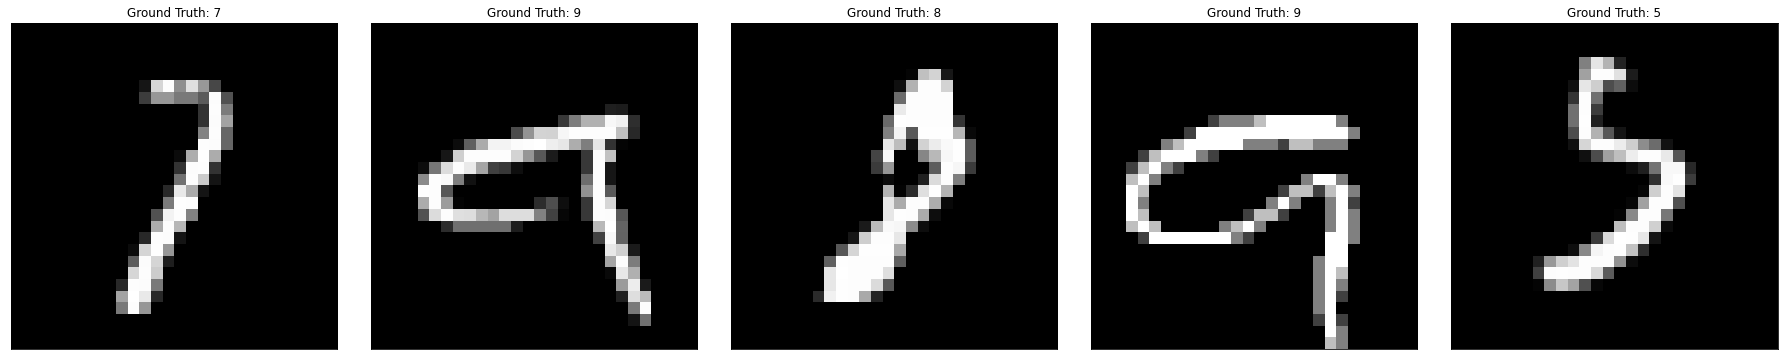

Adam train Data Size:  (540, 1, 28, 28)
Train Epoch: 1 [0/540 (0%)]	Loss: 1.176486
Train Epoch: 2 [0/540 (0%)]	Loss: 0.940519
Train Epoch: 3 [0/540 (0%)]	Loss: 1.019814
Train Epoch: 4 [0/540 (0%)]	Loss: 1.030279
Train Epoch: 5 [0/540 (0%)]	Loss: 1.115963
Train Epoch: 6 [0/540 (0%)]	Loss: 1.026101

Test set: Avg. loss: 0.2128, Accuracy: 9389/10000 (94%)



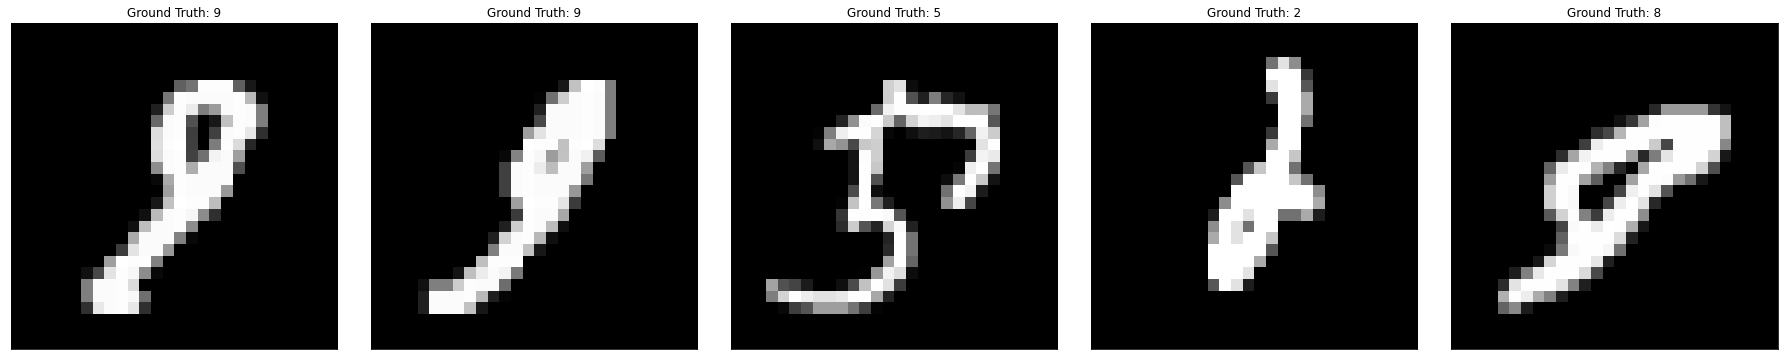

VOGN train Data Size:  (560, 1, 28, 28)
Train Epoch: 1 [0/560 (0%)]	Loss: 0.792173
Train Epoch: 2 [0/560 (0%)]	Loss: 0.768176
Train Epoch: 3 [0/560 (0%)]	Loss: 0.768005
Train Epoch: 4 [0/560 (0%)]	Loss: 0.759556
Train Epoch: 5 [0/560 (0%)]	Loss: 0.741725
Train Epoch: 6 [0/560 (0%)]	Loss: 0.735563

Test set: Avg. loss: 0.1831, Accuracy: 9442/10000 (94%)



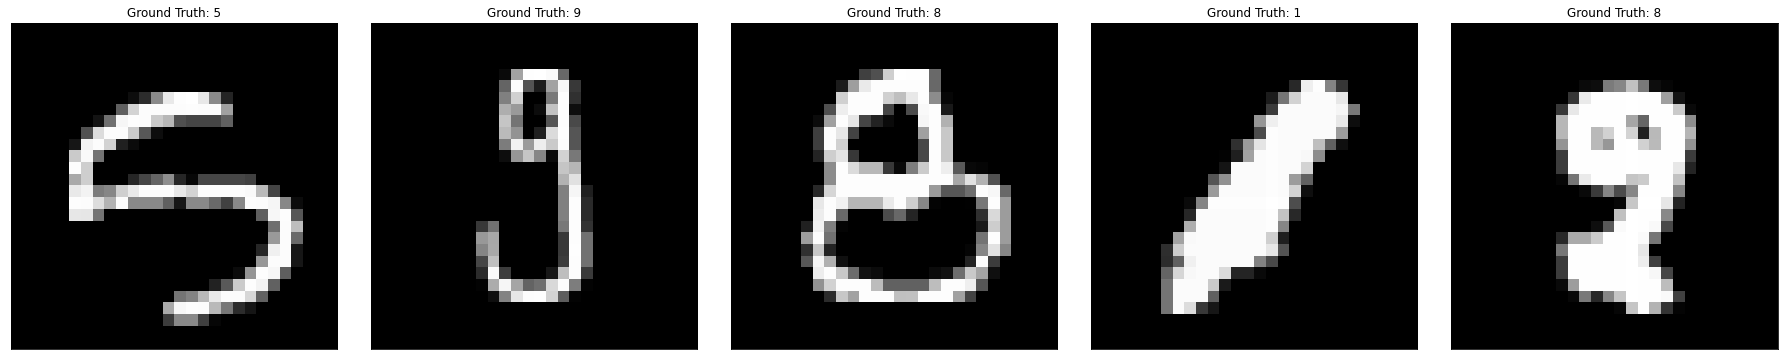

Adam train Data Size:  (560, 1, 28, 28)
Train Epoch: 1 [0/560 (0%)]	Loss: 0.997372
Train Epoch: 2 [0/560 (0%)]	Loss: 1.121675
Train Epoch: 3 [0/560 (0%)]	Loss: 0.829405
Train Epoch: 4 [0/560 (0%)]	Loss: 0.894281
Train Epoch: 5 [0/560 (0%)]	Loss: 1.200034
Train Epoch: 6 [0/560 (0%)]	Loss: 0.892233

Test set: Avg. loss: 0.2149, Accuracy: 9398/10000 (94%)



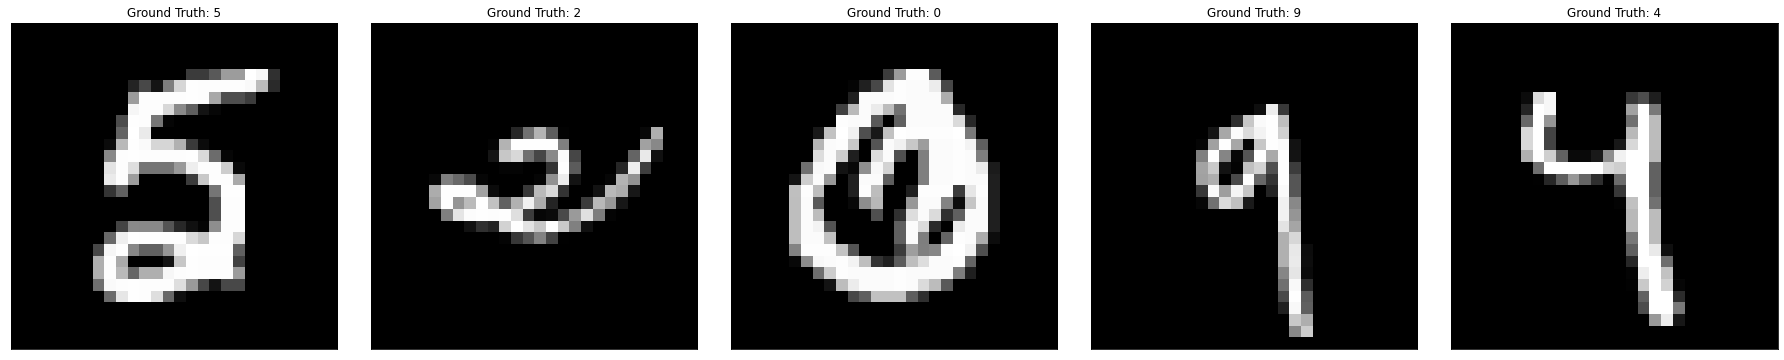

VOGN train Data Size:  (580, 1, 28, 28)
Train Epoch: 1 [0/580 (0%)]	Loss: 0.740797
Train Epoch: 2 [0/580 (0%)]	Loss: 0.724504
Train Epoch: 3 [0/580 (0%)]	Loss: 0.728269
Train Epoch: 4 [0/580 (0%)]	Loss: 0.715750
Train Epoch: 5 [0/580 (0%)]	Loss: 0.700474
Train Epoch: 6 [0/580 (0%)]	Loss: 0.718780

Test set: Avg. loss: 0.1786, Accuracy: 9449/10000 (94%)



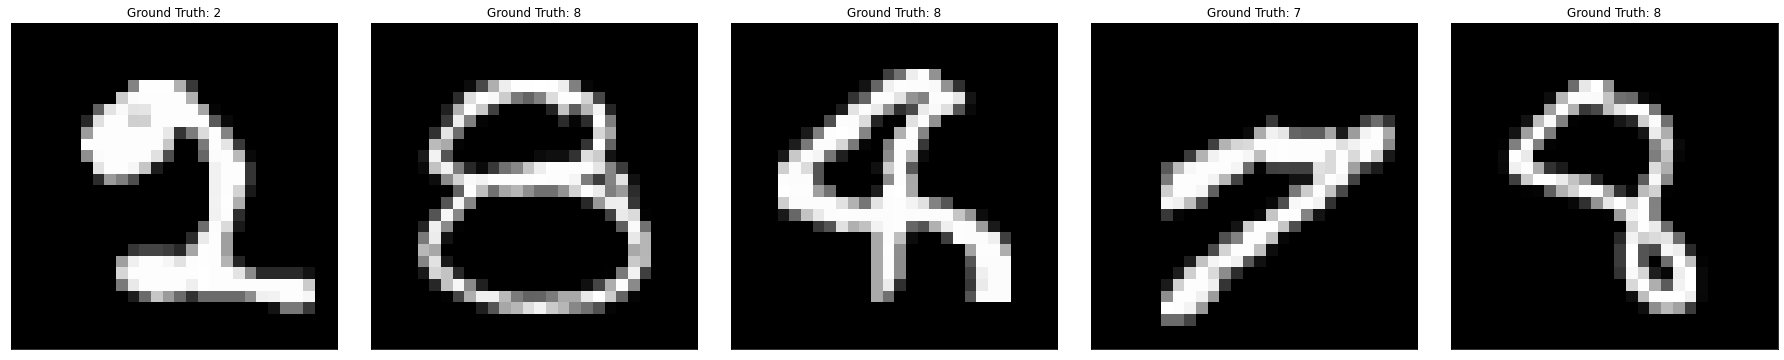

Adam train Data Size:  (580, 1, 28, 28)
Train Epoch: 1 [0/580 (0%)]	Loss: 0.827369
Train Epoch: 2 [0/580 (0%)]	Loss: 0.943121
Train Epoch: 3 [0/580 (0%)]	Loss: 1.109029
Train Epoch: 4 [0/580 (0%)]	Loss: 0.894486
Train Epoch: 5 [0/580 (0%)]	Loss: 0.885611
Train Epoch: 6 [0/580 (0%)]	Loss: 0.990377

Test set: Avg. loss: 0.2102, Accuracy: 9383/10000 (94%)



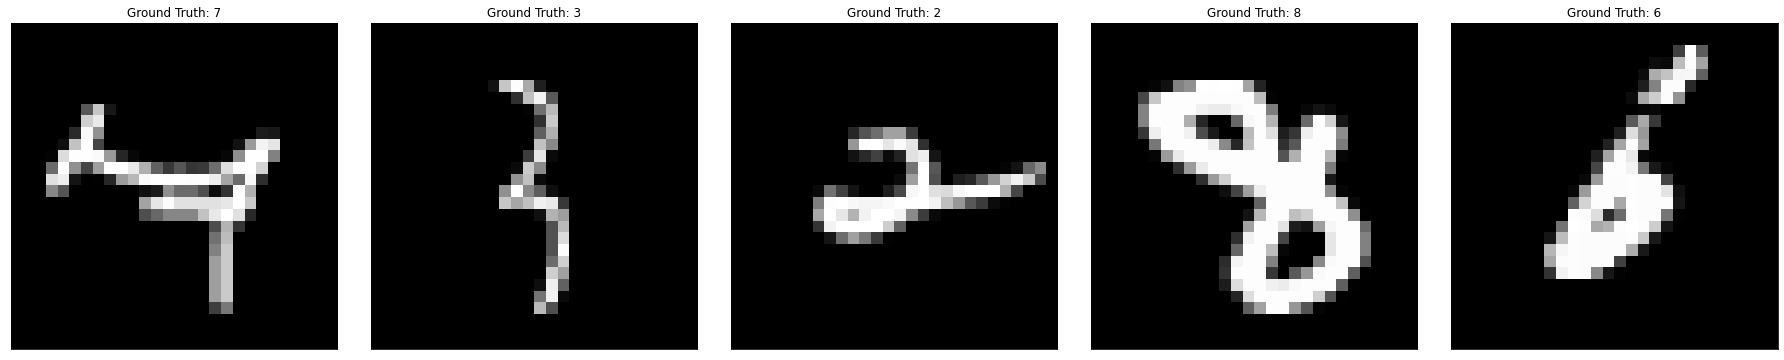

VOGN train Data Size:  (600, 1, 28, 28)
Train Epoch: 1 [0/600 (0%)]	Loss: 0.763303
Train Epoch: 2 [0/600 (0%)]	Loss: 0.726418
Train Epoch: 3 [0/600 (0%)]	Loss: 0.745814
Train Epoch: 4 [0/600 (0%)]	Loss: 0.742444
Train Epoch: 5 [0/600 (0%)]	Loss: 0.719130
Train Epoch: 6 [0/600 (0%)]	Loss: 0.725487

Test set: Avg. loss: 0.1756, Accuracy: 9467/10000 (95%)



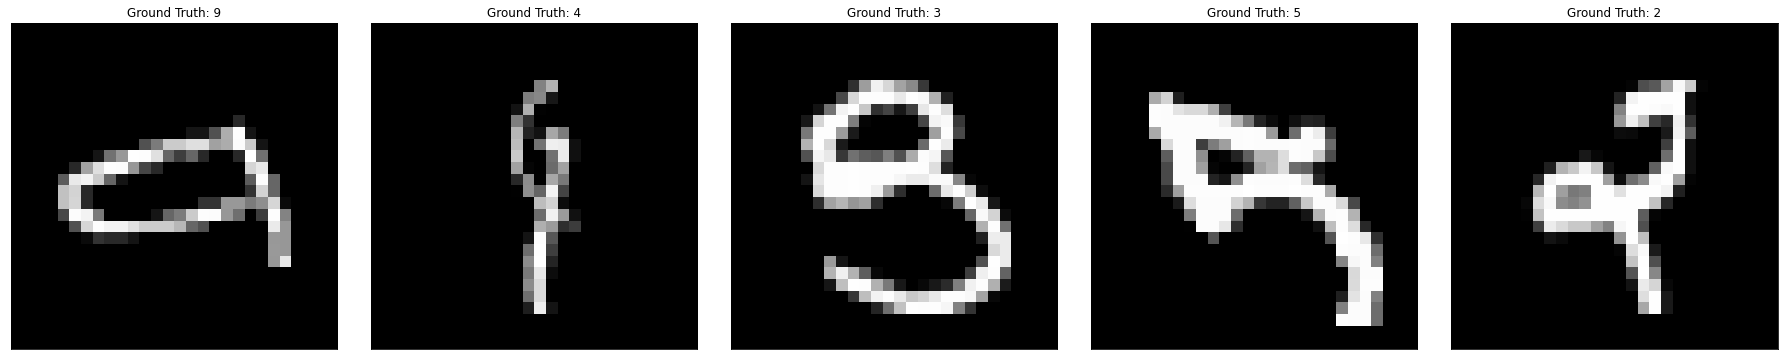

Adam train Data Size:  (600, 1, 28, 28)
Train Epoch: 1 [0/600 (0%)]	Loss: 1.142167
Train Epoch: 2 [0/600 (0%)]	Loss: 1.041962
Train Epoch: 3 [0/600 (0%)]	Loss: 0.949863
Train Epoch: 4 [0/600 (0%)]	Loss: 1.017501
Train Epoch: 5 [0/600 (0%)]	Loss: 0.988258
Train Epoch: 6 [0/600 (0%)]	Loss: 1.026515

Test set: Avg. loss: 0.2024, Accuracy: 9447/10000 (94%)



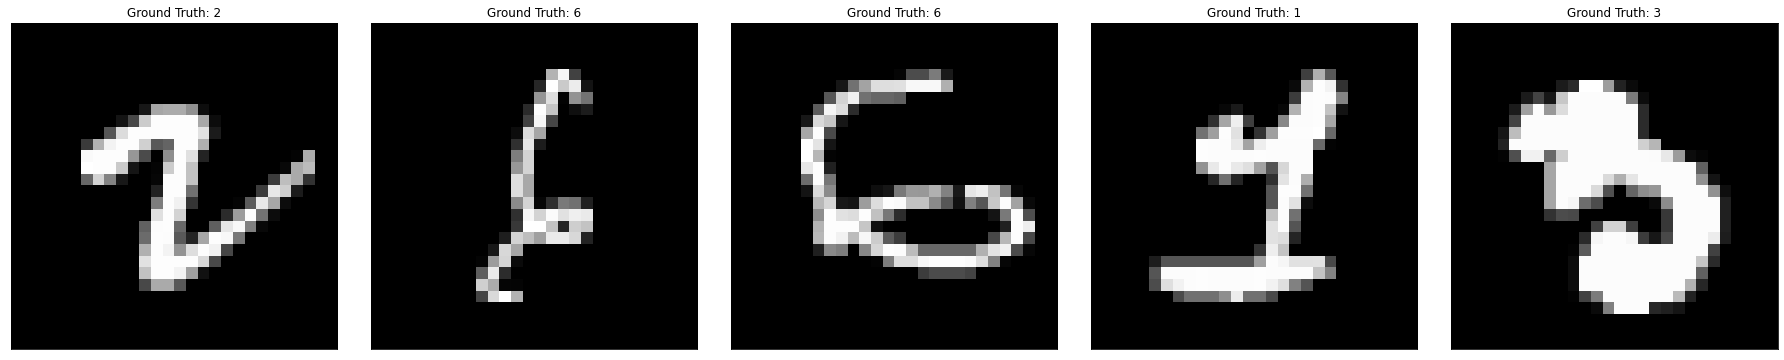

VOGN train Data Size:  (620, 1, 28, 28)
Train Epoch: 1 [0/620 (0%)]	Loss: 0.835979
Train Epoch: 2 [0/620 (0%)]	Loss: 0.799758
Train Epoch: 3 [0/620 (0%)]	Loss: 0.761138
Train Epoch: 4 [0/620 (0%)]	Loss: 0.804130
Train Epoch: 5 [0/620 (0%)]	Loss: 0.791501
Train Epoch: 6 [0/620 (0%)]	Loss: 0.771859

Test set: Avg. loss: 0.1758, Accuracy: 9474/10000 (95%)



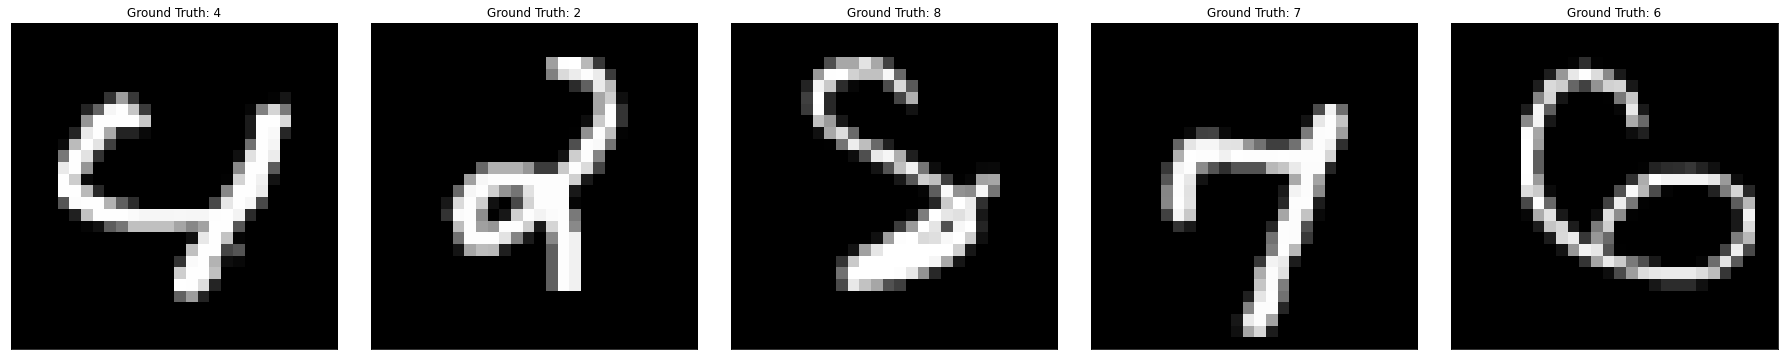

Adam train Data Size:  (620, 1, 28, 28)
Train Epoch: 1 [0/620 (0%)]	Loss: 1.035026
Train Epoch: 2 [0/620 (0%)]	Loss: 0.999594
Train Epoch: 3 [0/620 (0%)]	Loss: 0.896526
Train Epoch: 4 [0/620 (0%)]	Loss: 0.891768
Train Epoch: 5 [0/620 (0%)]	Loss: 1.000949
Train Epoch: 6 [0/620 (0%)]	Loss: 0.755861

Test set: Avg. loss: 0.1946, Accuracy: 9407/10000 (94%)

VOGN train Data Size:  (640, 1, 28, 28)
Train Epoch: 1 [0/640 (0%)]	Loss: 0.769007


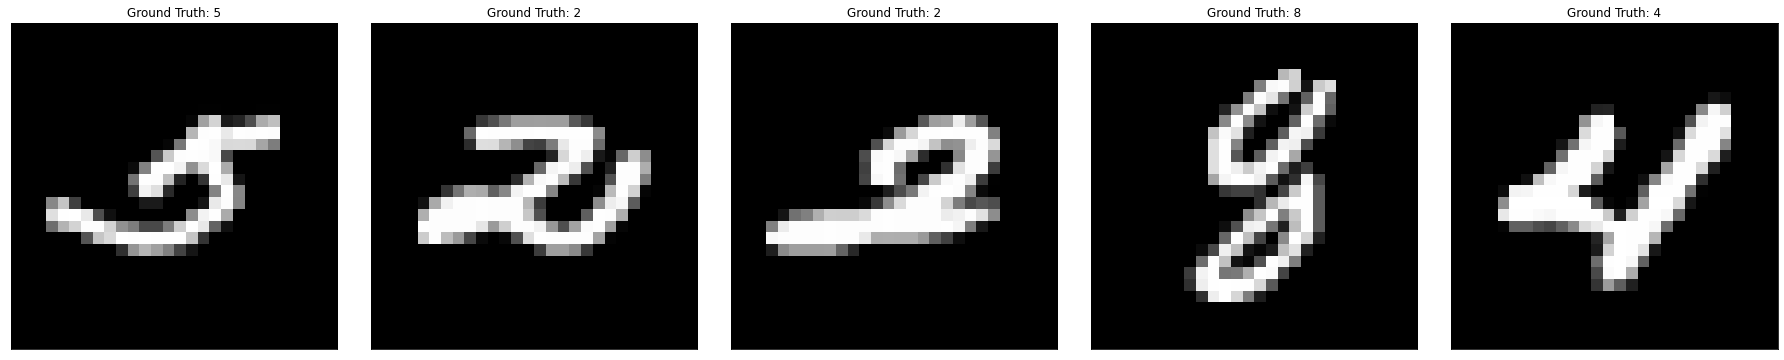

Train Epoch: 2 [0/640 (0%)]	Loss: 0.765355
Train Epoch: 3 [0/640 (0%)]	Loss: 0.728988
Train Epoch: 4 [0/640 (0%)]	Loss: 0.733482
Train Epoch: 5 [0/640 (0%)]	Loss: 0.743884
Train Epoch: 6 [0/640 (0%)]	Loss: 0.734400

Test set: Avg. loss: 0.1641, Accuracy: 9509/10000 (95%)



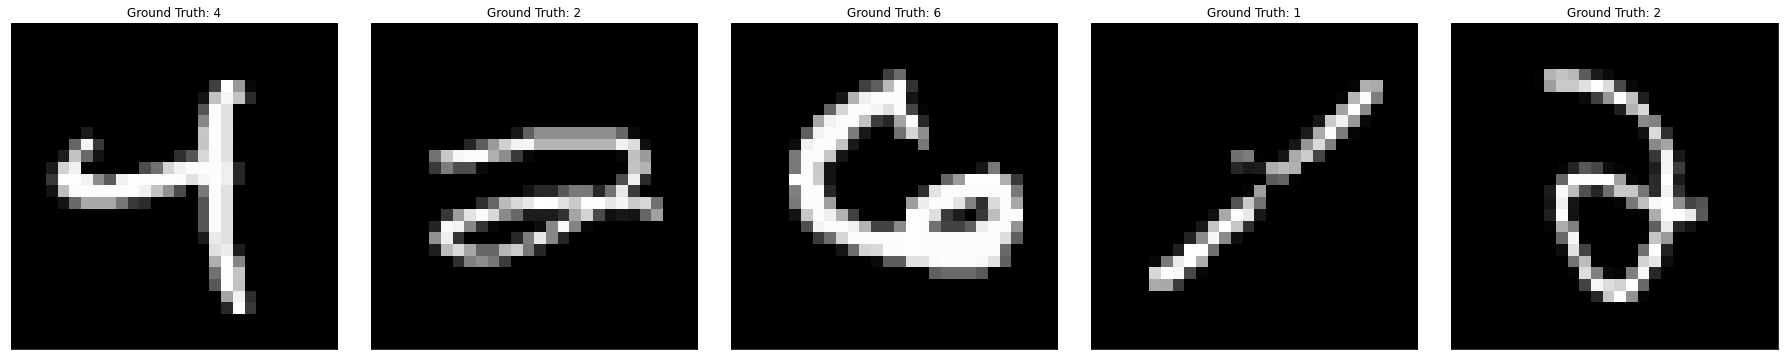

Adam train Data Size:  (640, 1, 28, 28)
Train Epoch: 1 [0/640 (0%)]	Loss: 0.985183
Train Epoch: 2 [0/640 (0%)]	Loss: 0.930031
Train Epoch: 3 [0/640 (0%)]	Loss: 0.851819
Train Epoch: 4 [0/640 (0%)]	Loss: 0.735615
Train Epoch: 5 [0/640 (0%)]	Loss: 0.886382
Train Epoch: 6 [0/640 (0%)]	Loss: 1.023664

Test set: Avg. loss: 0.1684, Accuracy: 9488/10000 (95%)

VOGN train Data Size:  (660, 1, 28, 28)
Train Epoch: 1 [0/660 (0%)]	Loss: 0.740294


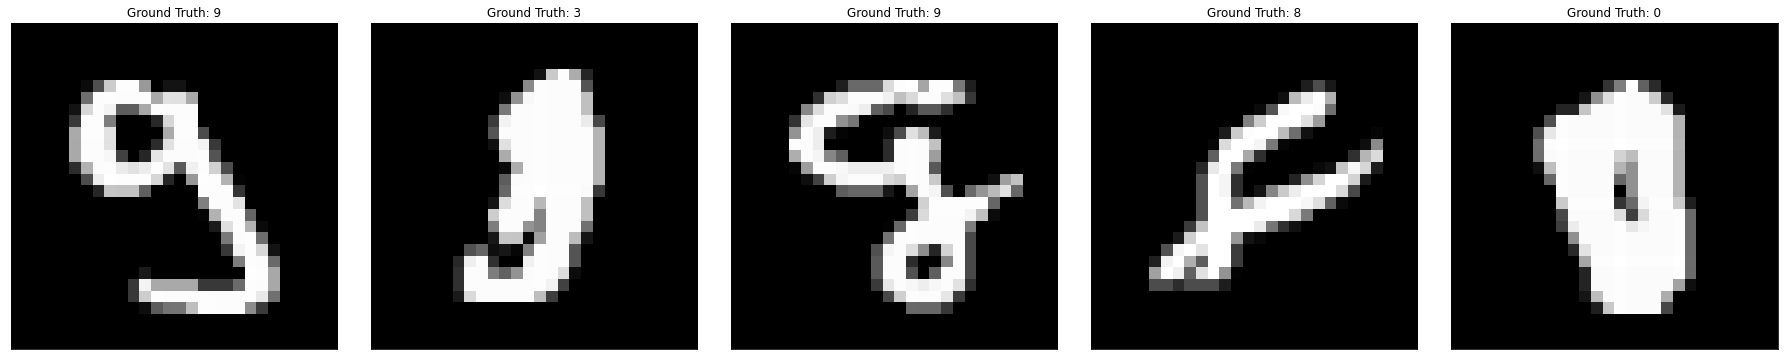

Train Epoch: 1 [200/660 (91%)]	Loss: 0.676312
Train Epoch: 2 [0/660 (0%)]	Loss: 0.736635
Train Epoch: 2 [200/660 (91%)]	Loss: 0.623749
Train Epoch: 3 [0/660 (0%)]	Loss: 0.723426
Train Epoch: 3 [200/660 (91%)]	Loss: 0.613945
Train Epoch: 4 [0/660 (0%)]	Loss: 0.722400
Train Epoch: 4 [200/660 (91%)]	Loss: 0.557254
Train Epoch: 5 [0/660 (0%)]	Loss: 0.700672
Train Epoch: 5 [200/660 (91%)]	Loss: 0.548437
Train Epoch: 6 [0/660 (0%)]	Loss: 0.702526
Train Epoch: 6 [200/660 (91%)]	Loss: 0.539807

Test set: Avg. loss: 0.1529, Accuracy: 9520/10000 (95%)



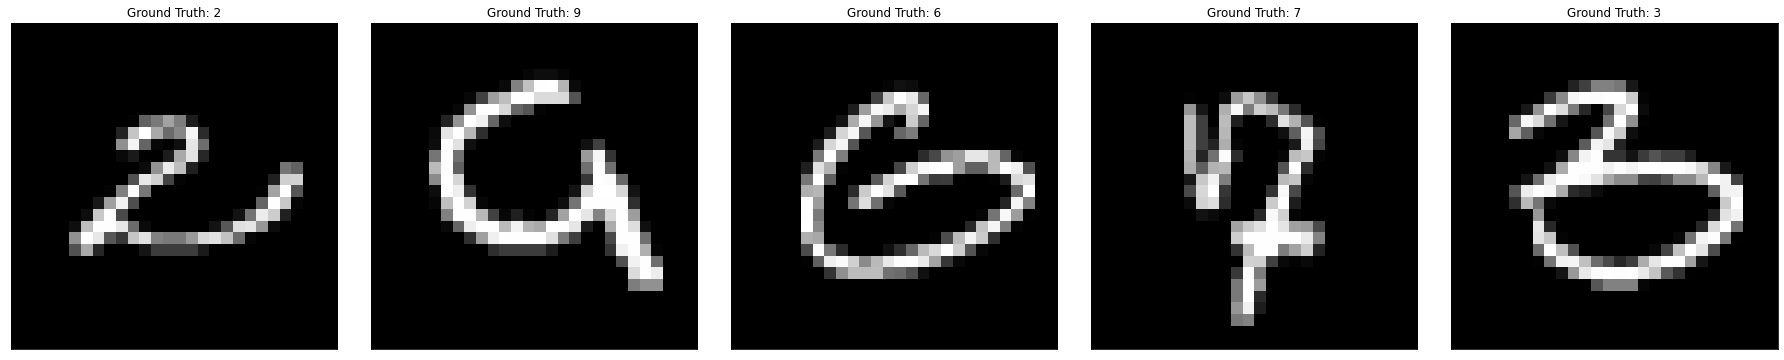

Adam train Data Size:  (660, 1, 28, 28)
Train Epoch: 1 [0/660 (0%)]	Loss: 0.718706
Train Epoch: 1 [200/660 (91%)]	Loss: 0.901903
Train Epoch: 2 [0/660 (0%)]	Loss: 0.917664
Train Epoch: 2 [200/660 (91%)]	Loss: 0.349855
Train Epoch: 3 [0/660 (0%)]	Loss: 0.803896
Train Epoch: 3 [200/660 (91%)]	Loss: 0.775694
Train Epoch: 4 [0/660 (0%)]	Loss: 1.001400
Train Epoch: 4 [200/660 (91%)]	Loss: 0.366803
Train Epoch: 5 [0/660 (0%)]	Loss: 0.723213
Train Epoch: 5 [200/660 (91%)]	Loss: 0.441445
Train Epoch: 6 [0/660 (0%)]	Loss: 1.032489
Train Epoch: 6 [200/660 (91%)]	Loss: 0.888841

Test set: Avg. loss: 0.1851, Accuracy: 9493/10000 (95%)

VOGN train Data Size:  (680, 1, 28, 28)
Train Epoch: 1 [0/680 (0%)]	Loss: 0.713984


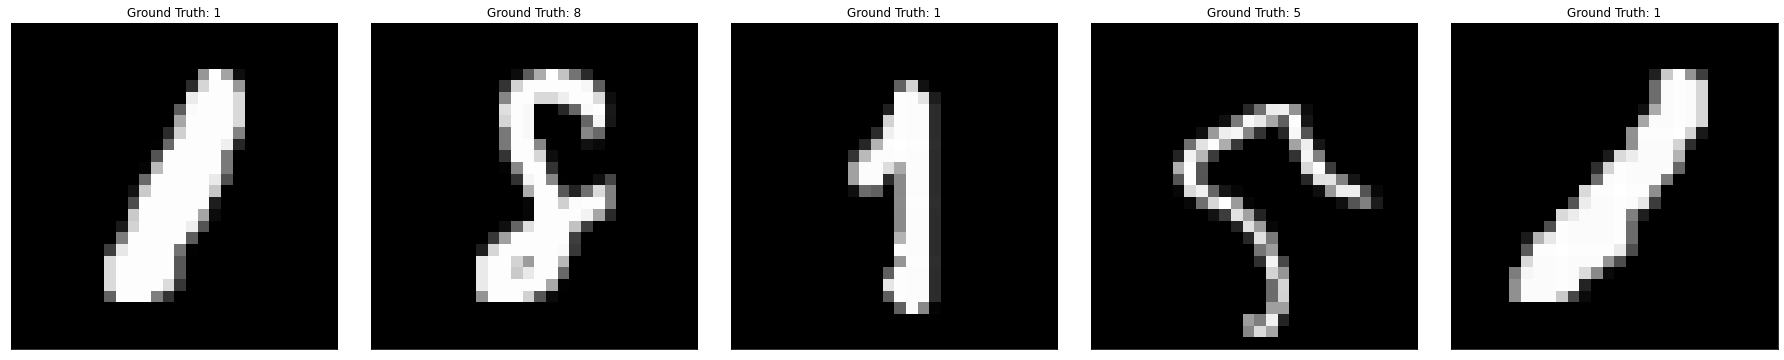

Train Epoch: 1 [400/680 (91%)]	Loss: 0.665056
Train Epoch: 2 [0/680 (0%)]	Loss: 0.685376
Train Epoch: 2 [400/680 (91%)]	Loss: 0.685583
Train Epoch: 3 [0/680 (0%)]	Loss: 0.708430
Train Epoch: 3 [400/680 (91%)]	Loss: 0.659011
Train Epoch: 4 [0/680 (0%)]	Loss: 0.685874
Train Epoch: 4 [400/680 (91%)]	Loss: 0.650354
Train Epoch: 5 [0/680 (0%)]	Loss: 0.683307
Train Epoch: 5 [400/680 (91%)]	Loss: 0.642064
Train Epoch: 6 [0/680 (0%)]	Loss: 0.664894
Train Epoch: 6 [400/680 (91%)]	Loss: 0.653792

Test set: Avg. loss: 0.1405, Accuracy: 9583/10000 (96%)



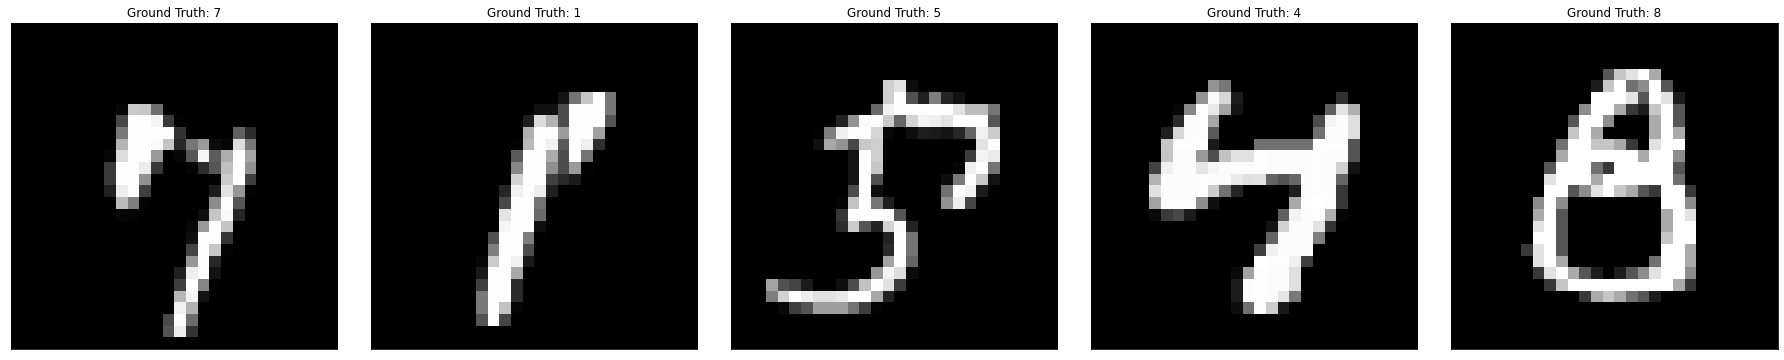

Adam train Data Size:  (680, 1, 28, 28)
Train Epoch: 1 [0/680 (0%)]	Loss: 1.132668
Train Epoch: 1 [400/680 (91%)]	Loss: 0.731590
Train Epoch: 2 [0/680 (0%)]	Loss: 0.855272
Train Epoch: 2 [400/680 (91%)]	Loss: 1.053214
Train Epoch: 3 [0/680 (0%)]	Loss: 0.751756
Train Epoch: 3 [400/680 (91%)]	Loss: 0.617680
Train Epoch: 4 [0/680 (0%)]	Loss: 1.137332
Train Epoch: 4 [400/680 (91%)]	Loss: 0.323202
Train Epoch: 5 [0/680 (0%)]	Loss: 0.808456
Train Epoch: 5 [400/680 (91%)]	Loss: 0.696079
Train Epoch: 6 [0/680 (0%)]	Loss: 0.645220
Train Epoch: 6 [400/680 (91%)]	Loss: 0.465074

Test set: Avg. loss: 0.1541, Accuracy: 9557/10000 (96%)



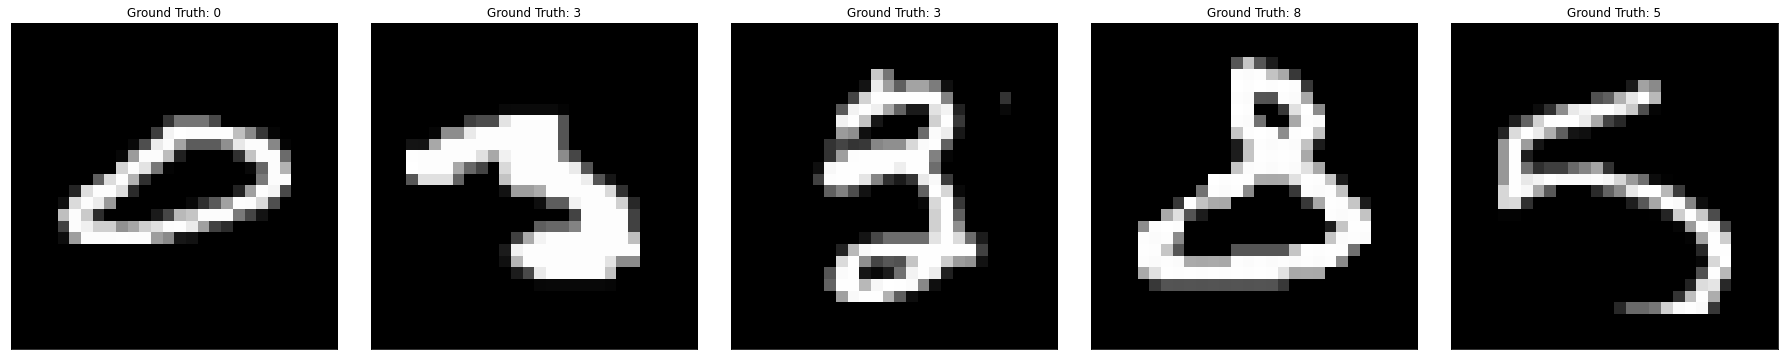

In [21]:
# Active learning Implementation

train_inds_vogn = {} 
train_inds_adam = {}
high_entropy_for_vogn = {}
high_entropy_for_adam = {}

inds = list(range(N))
random.shuffle(inds)

# Setting up points for 1st iteration
for i in range(N_initial): # 10 points for 1st iteration
  train_inds_vogn[inds[i]] = True
  high_entropy_for_vogn[inds[i]] = True
  train_inds_adam[inds[i]] = True
  high_entropy_for_adam[inds[i]] = True
  

for itr in range(N_iter):# N_iter = 25 
  # setting training data in readable format
  X_train, y_train = get_train_data(X_pool, y_pool, train_inds_vogn)
  X_train_adam, y_train_adam = get_train_data(X_pool, y_pool, train_inds_adam) 
  
  print("VOGN train Data Size: ", X_train.shape)

  train_itr = get_tensor_iterator(X_train, y_train, batch_size_train)

  # Training and testing 
  for epoch in range(1, n_epochs + 1):
    train(train_itr, epoch)
  test()

  # Calculating high entropy indices
  high_entropy_inds_vogn = get_high_entropy_indices(train_inds_vogn, X_pool, y_pool, algo="vogn")

  # Concatinating the calculated high_entropy_indices to the training data
  high_entropy_for_vogn = {} 
  for ind in high_entropy_inds_vogn:
    if(ind in train_inds_vogn):
      print("Not Expected ;(")
    train_inds_vogn[ind] = True
    high_entropy_for_vogn[ind] = True
  
  # Plotting the high entropy indices
  fig = plt.figure()
  fig.set_figheight(50)
  fig.set_figwidth(25)
  for i in range(min(N_add,5)):
    plt.subplot(25//5, 5, i+1)
    plt.tight_layout()
    plt.imshow(X_pool[high_entropy_inds_vogn[i]][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(y_pool[high_entropy_inds_vogn[i]]))
    plt.xticks([])
    plt.yticks([])
  
  plt.show()

  # Repeating the same for Adam
  print("Adam train Data Size: ", X_train_adam.shape)

  train_itr_adam = get_tensor_iterator(X_train_adam, y_train_adam, batch_size_train)

  for epoch in range(1, n_epochs + 1):
    train(train_itr_adam, epoch, algo="adam")
  test(algo="adam")

  high_entropy_inds_adam = get_high_entropy_indices(train_inds_adam, X_pool, y_pool, algo="adam")
  
  high_entropy_for_adam = {}

  for ind in high_entropy_inds_adam:
    if(ind in train_inds_adam):
      print("Not Expected ;(")
    train_inds_adam[ind] = True
    high_entropy_for_adam[ind] = True

  fig = plt.figure()
  fig.set_figheight(50)
  fig.set_figwidth(25)
  for i in range(min(N_add,5)):
    plt.subplot(5, 5, i+1)
    plt.tight_layout()
    plt.imshow(X_pool[high_entropy_inds_adam[i]][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(y_pool[high_entropy_inds_adam[i]]))
    plt.xticks([])
    plt.yticks([])
  
  plt.show()

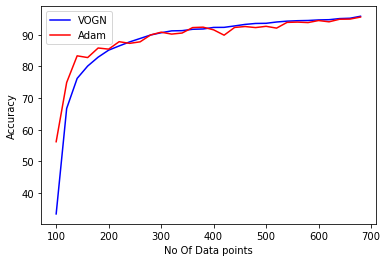

In [22]:
# Visualizing the performance of Adam and VOGN
plt.plot(range(N_initial,N_initial + (len(test_acc))*(N_add),N_add),test_acc, 'b')
plt.plot(range(N_initial,N_initial + (len(test_acc_adam))*(N_add),N_add),test_acc_adam, 'r')
plt.xlabel("No Of Data points")
plt.ylabel("Accuracy")
plt.legend(["VOGN", "Adam"])